<h1> Imports </h1>
All imports required for the program. 

In [2]:
# Generally useful
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Path
import os
import sys

# Callum imports
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d

# Arnold imports
from scipy.stats import describe
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import shutil

<h1> Classifier Class </h1>
This class can be used to classify datasets, if they need to be separated for further analysis. <br>
It uses a keras Sequential Neural Network (NN). The class can create a training dataset by giving the directory as input. <br>
Afterwards, only the labels need to be input manually in the features.xlsf file created. The NN learns from this file, and is stored on the machine and in the class. New data can be input later, which can be classified by the previously trained NN. 

In [3]:
class Classifier(object):
    '''
    Class that can be used to classify datasets based upon an existing Sequential model 
    or by creating a new model.
    Main Methods:
    create_features() - calculates features from a dataset, use in a loop to stack multiple datasets in a single file
    create_trainingdata() - creates training data for model by using the features, if no model is present the labels 
    to be classified must be added.
    create_NN() - creates a Sequential model that trains on the features and labels. The model is saved on the system and in the class itself.
    test_NN() - test the model on a features.xlsf file, all positive findings are put into a seperate directory
    '''
    def __init__(self, rootdir, model=None):
        self.rootdir = rootdir
        self.model = model
        self.iandv = pd.DataFrame()
        self.features = pd.DataFrame()
        
    def create_features(self, df, iandv, features, expnr, filelocation, filelocationlist):
        '''
        Helper function for create_trainingdata. 
        Creates features for a dataset. Can be used in a loop to gather multiple datasets 
        in a single features and iandv dataframe. To start off, iandv and features must empty DataFrame() 
        Returns df, iandv, features, expnr and filelocationlist.
        '''
        # Obtain IV columns and select features
        firsttwocol = df.iloc[:, [0, 1]].dropna()

        # Check if any of the two columns are not empty and check for enough data points
        if not firsttwocol.empty and len(firsttwocol.index) > 30:
            # make sure the plots aren't skewed, take mean of first and last n points to draw slope
            n = 10
            a = (np.mean(firsttwocol.iloc[(2 * -n):-n, 1]) - np.mean(firsttwocol.iloc[n:(2 * n), 1])) \
                / (np.mean(firsttwocol.iloc[(2 * -n):-n, 0]) - np.mean(firsttwocol.iloc[n:(2 * n), 0]))
            b = firsttwocol.iloc[:, 1] - a * firsttwocol.iloc[:, 0]
            firsttwocol.iloc[:, 1] = firsttwocol.iloc[:, 1] - a * firsttwocol.iloc[:, 0] + b

            # Obtain data
            iandv = pd.concat([iandv, firsttwocol], axis=1)
            stats = describe(firsttwocol.iloc[:, 1])
            gradient = np.gradient(firsttwocol.iloc[:, 1])
            statsgrad = describe(gradient)
            features = features.append([(stats.mean, stats.variance, stats.skewness, stats.kurtosis, statsgrad.mean,
                                         statsgrad.variance, statsgrad.skewness, statsgrad.kurtosis)])


            # Up the counter
            expnr += 1
            
            # Valid filelocations
            filelocationlist.append(filelocation)

        return df, iandv, features, expnr, filelocationlist
    
    
    def create_trainingdata(self):
        '''
        Creates training data by using the features made in create_features(). Labels need to be manually input in the 
        features.xlsf file             NOTE: MIGHT CHANGE IN THE FUTURE!!
        '''
        # EXAMPLE: rootdir = r'C:\Users\arnol\Desktop\newproject\SAFARI TES data\Selection'
        Path(self.rootdir + r"\Plots").mkdir(parents=True, exist_ok=True)
        save_plots_to = self.rootdir + r'\Plots'
        filelocationlist = []

        extensions = '.qdp'
        iandv = self.iandv
        features = self.features
        expnr = 1
        errorcount = 0

        # Extract df, iandv, features, expnr from .qdp files
        for subdir, dirs, files in os.walk(self.rootdir):
            for file in files:
                if file[0] == 'I':  # If starting with I to make sure other files are excluded
                    ext = os.path.splitext(file)[-1].lower()
                    if ext == '.qdp':
                        filelocation = os.path.join(subdir, file)
                        # If file cannot be read, display error
                        try:
                            df = read_qdp(filelocation, expnr)
                            df, iandv, features, expnr, filelocationlist = self.create_features(df, iandv, features, expnr, 
                                                                                                filelocation, filelocationlist)
                        except (pd.errors.ParserError, pd.errors.EmptyDataError):
                            errorcount += 1
                            print(filelocation)

        print(str(expnr-1) + " files loaded")
        print("The above " + str(errorcount) + " file(s) were invalid and skipped, \
                        please check formats manually. Continuing...")
        

        # Output filelocationlist.txt
        filelocationlistfile = open('filelocationlist.txt', 'w')
        for filelocation in filelocationlist:
            filelocationlistfile.write(filelocation)
            filelocationlistfile.write('\n')
        filelocationlistfile.close()

        # Convert to .xlsx files
        iandv.to_excel('iandv.xlsx', index=False)
        features.columns = ['mean', 'std', 'skewness', 'kurtosis', 'grad mean', 'grad std', 'grad skewness', 'grad kurtosis']
        features = (features - features.mean()) / features.std()
        features.to_excel('features.xlsx', index=False)

        # Plot where the i + 1 means you can more easily compare rows in .xlsx files with plots as headers are in row 1
        for i in range(1, expnr):
            iandv.plot(kind='scatter', x='Current ' + str(i + 1) + ' (I)', y='V_fb ' + str(i + 1) + ' (V)', color='red')
            plt.savefig(save_plots_to + r'\row ' + str(i + 1) + '.png', dpi=300)
            plt.close('all')
            
        # Update the initialised dataframes
        self.iandv = iandv
        self.features = features
              
              
    def create_NN(self, rootfolder):
        '''
        Create a Sequential Neural Network to train on the labelled training data set. 
        Functions return nothing, as the model is saved on disk. 
        '''
        # EXAMPLE: rootfolder = r'C:\Users\arnol\Desktop\newproject'
        Y, Y_train, Y_test = {}, {}, {}

        # The eight feature columns are made in create_trainingdata() and are constant
        BEGIN_COLUMN_FEATURE = 0            
        END_COLUMN_FEATURE = 8              # This label needs to be 1 higher than the actual column label count

        # These depend upon how many labels are added and where they are added
        begin_column_label = 9
        end_column_label = 10               # This label needs to be 1 higher than the actual column label count

        # load the dataset
        dataset = pd.read_excel(os.path.join(rootfolder, r'features.xlsx'))
        print(dataset.head())

        # Split into input (X) and output (Y) variables
        X = dataset.iloc[:, :END_COLUMN_FEATURE]  # Up to and not including column 8

        # For each label, the model is trained with 150 epochs
        for i in range(begin_column_label, end_column_label):  # Label columns
            Y[i] = dataset.iloc[:, i]

            # Split in training and testset
            X_train, X_test, Y_train[i], Y_test[i] = train_test_split(X, Y[i], test_size=0.2)

            # Define the keras model
            model = Sequential()
            model.add(Dense(12, input_dim=8, activation='relu'))
            model.add(Dense(8, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

            # Compile the keras model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Fit the keras model on the training dataset
            model.fit(X_train, Y_train[i], epochs=150, batch_size=10)

            # Make class predictions with the model for data X_test
            predictions = model.predict_classes(X_test)

            # Give accuracy for all data input cases
            for j in range((len(X_test))):
                print('%s => %d (expected %d)' % (X_test.iloc[j].tolist(), predictions[j], Y_test[i].iloc[j]))

            # Print confusion matrix
            print("Confusion matrix:\n", confusion_matrix(Y_test[i], predictions, labels=None, sample_weight=None,
                                                          normalize=None))
            # Save models
            model.save('model ' + dataset.columns[i])
            self.model = model

        print("Saved models to disk")
        return model
              
              
    def test_NN(self, rootfolder):
        '''
        Test the NN made in create_NN(). All datasets that were tested positively are deposited 
        in a seperate depository for analysis. Functions returns nothing.
        '''
        #rootfolder = r'C:\Users\arnol\Desktop\newproject'

        BEGIN_COLUMN_FEATURE = 0  # remember python starts counting at 0
        END_COLUMN_FEATURE = 8

        begin_column_label = 9
        end_column_label = 10  # change this line to add more classes

        positivenrlist = []
        qspname = open('filelocationlist.txt', 'r')
        qsp_data = qspname.readlines()

        for i in range(begin_column_label, end_column_label):

            # Load dataset
            dataset_uncut = pd.read_excel(os.path.join(rootfolder, r'features.xlsx'))
            dataset = dataset_uncut.iloc[:, :END_COLUMN_FEATURE]

            # Load model    
            if self.model != None:
                model = self.model
            else:
                model = load_model('model ' + dataset_uncut.columns[i])

            # Evaluate the model
            predictions = model.predict_classes(dataset)

            for j in range((len(dataset))):
                if predictions[j] == 1:
                    positivenrlist.append(str(j + 2))  # + 2 so 0 becomes 2 to correspond to features.xlsx file rows
            print("The following rows were tested positive for " + dataset_uncut.columns[i]
                  + ': ' + ', '.join(positivenrlist))
            print("The corresponding .qsp filenames are stored in Positive " + dataset_uncut.columns[i] +
                  ' and copied to the Positives folder.')

            positivenamelist = open('Positive ' + dataset_uncut.columns[i] + '.txt', 'w+')
            for number in positivenrlist:
                positivenamelist.write(qsp_data[int(number) - 2])  # - 2 to account for previous + 2
            positivenamelist.close()

            # Copy all the .qsp files that were tested positive to their designated folders
            #target = os.path.join(rootfolder, r'SAFARI TES data\Selection\positives', dataset_uncut.columns[i])
            target = os.path.join(rootfolder, dataset_uncut.columns[i])
            if not os.path.exists(target):
                os.mkdir(target)

            positivenamelist = open('Positive ' + dataset_uncut.columns[i] + '.txt', 'r+')
            for line in positivenamelist.readlines():
                shutil.copy(line.strip(), target)
            positivenamelist.close()

            positivenrlist.clear()

        qspname.close()

<h1>IV_curve_double Class</h1>
Each dataset is stored inside an <code>IV_curve</code> class.
This class contains different methods to calculate certain values and plot different characteristics of the dataset

In [4]:
class IV_curve_double(object):
    '''
    Main Methods:
    self.plotPV() - Plot PV graph
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    '''
    
    def __init__(self, rawIV, params = 0, name='NA', tweaks = [1,1,1]):
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two columns of the dataframe and saves them as attributes. Next two columns will 
        be checked for T_BB and T_bath variables, but will be set to zero when not found. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be included as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attributes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - Whether the data shows signs of superconductivity
        y_offset (float) - Offset in the 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- Experimental parameters
        gain (float) - Calculated from M_ratio and R_fb
        R_stray (float) - Either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range
        '''
        
        # Raw data
        self.df = rawIV
        
        # Drop NaNs in spreadsheet to prevent errors later 
        rawI = (rawIV.iloc[:,0].dropna()).values  # Store as individual np.arrays for more readable code
        self.rawI = [entry * tweaks[0] for entry in rawI]
        rawV = (rawIV.iloc[:,1].dropna()).values
        self.rawV = [entry * tweaks[1] for entry in rawV]
        
        # Search next columns for T_BB and T_bath, if non existent set them to 0.1 
        try:
            self.T_BB = rawIV.iloc[:,3].dropna().values
            self.T_bath = rawIV.iloc[:,4].dropna().values
        except IndexError:
            print("T_BB and T_bath not found")
            self.T_BB = 0.1
            self.T_bath = 0.1
            
        self.P = False
        
        # Obtaining Power Data if present in the raw data
        try:
            assert len(rawIV.columns) > 5
            self.P_BB = (rawIV.iloc[:,-1]).dropna()
            for entry in self.P_BB:
                if entry != 0:
                    self.P = True
        except:             # Find out which exeption (AssertionError or IndexError)
            print("Failed to parse Power Data")
        
        self.raw_grad = np.gradient(self.rawV, self.rawI) # Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend on it
        
        # Initialise these values with the methods
        self.name = name
        self.y_offset = 0
        
        # Parameters needed to calculate V_bias and I_TES. Defaults are used when not provided. 
        # I DO NOT KNOW WHERE THESE DEFAULT NUMBERS ARE BASED ON, ASK CALLUM
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except IndexError:
                print("Error: Parameters not correct")
                return
        else:
            print("WARNING: Using default parameters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        
    ############################# Calculation Methods ##########################################   
    # For formulas see Callum's Thesis
    
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_TES (array) data from the y_offset (float), gain (float) and voltage (array).
        '''
        self.I_TES = [(self.rawV[i] - self.y_offset) * (10**6) * self.gain for i in range(len(self.rawV))]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generate V_bias (array) data from R_shunt (float), R_stray(float), rawI (array) and I_TES (array)
        '''
        self.V_bias = [((self.rawI[i]) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        '''
        Generate P_TES (array) data from I_TES (array) and V_bias (array) 
        '''
        self.P_TES = [self.I_TES[i] * self.V_bias[i] for i in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        '''
        Generate R_TES (array) data from V_bias (array) and I_TES (array)
        '''
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Tests if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        NOTE: Might be deprecated after classifying is introduced
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if abs(min(grad)) > 2*(grad_av) and min(grad) < 0:
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    def calc_all(self):
        '''
        Calculates all values used for the plots and analysis.
        NOTE: Maybe implement calc_rnn func, so it doesn't need to be done in the plotIV function
        '''       
        self.power_readout()
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.reverse_y_offset()
        
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.calc_P_TES()
        self.calc_R_TES()
        self.power_readout(True)
    
    ############################ Utility methods ############################   
    
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
        
    def fit_ohmic(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        # First 10 points and last 10 points taken to fit straight line through both ohmic regions.
        # This could be automated to rely less on just choosing a random number.
        r1start, r1end = (0,10)   
        r2start, r2end = (-10,-1)
        
        firstx = min(inputdataX)
        lastx = max(inputdataX)
        xvals = np.linspace(firstx, lastx)

        # Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:r1end]
        yvals2 = inputdataY[r2start:r2end]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdataX[r1start:r1end]
        xvals2 = inputdataX[r2start:r2end]
        lineDataX = np.append(xvals1, xvals2)

        # Fit the sliced data to a line
        C, D = curve_fit(self.f, lineDataX, lineDataY)[0]
        print("C: ", str(C))
        print("D: ", str(D))
        
        return C, D, xvals
    
    def power_readout(self, plot = 0):
        '''
        Looks for turning points from positive to negative gradient, as that denotes a different region.
        RETURNS: indices of the turning points and the corresponding power values
        '''
        indices = []
        
        # Look for three consecutive negative gradients and add the index of the first point to a list
        count = 0 
        for index in range(len(self.raw_grad)):
            if self.raw_grad[index] < 0:
                count += 1
            else:
                count = 0
                
            if count >= 3:
                indices.append(index-count)
                break
        
        # Same procedure but from the other side
        # NOTE: IMPLIES SYMMETRY, CHECK FOR SINGLE SIDED???
        count = 0
        for index in range(len(self.raw_grad)):
            if self.raw_grad[-index] < 0:
                count += 1
            else:
                count = 0
                
            if count >= 3:
                indices.append(-(index-count))
                break
        
        # Dependent upon the amount of points, change readout value
        readout = 0  
        if plot:
            if len(indices) == 2:
                readout = (self.P_TES[indices[0]] +  self.P_TES[indices[1]])/2
            elif len(indices) == 1:
                readout = self.P_TES[indices[0]]
            else:
                readout = 0
        
        self.readout_idx = indices
        self.readout = readout
        return readout
    
    def reject_outliers(self, data, m = 2.):
        '''
        Rejects outliers from the dataset, look into how it works!!!
        '''
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def y_search(self, step, pivot, precision):
        '''
        Recursive function where the step gets lowered continously until it is at the provided precision level.
        Returns pivot, the y_offset.
        '''
        ys = []
        counts = []
        
        # Recursive loop end 
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        # Loop over a small range of values around pivot, and saves value with lowest count
        for y_off in np.arange(pivot-(step*10), pivot+(step*10), step/10):
            # Necessary calculations for R_TES and P_TES
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[i] * V_bias[i] for i in range(len(I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            
            #  
            count = 0          
            for i in range(int(len(R_TES)/10)-1):
                count += np.sqrt((R_TES[i] - R_TES[-i])**2)
                count += (R_TES[i] - self.rnn)**2
                count += (R_TES[-i] - self.rnn)**2
                
            count += len(R_TES)*(self.rnn - max(R_TES))**2
            
            for entry in P_TES:
                if entry < 0:
                    count += 10 * (entry**2)
            
            for entry in R_TES:
                if entry < 0:
                    count += 10 * (entry**2)
            
                
            counts.append(count)
            ys.append(y_off)

        y_offset = ys[np.argmin(counts)]

        return self.y_search(step/10, y_offset, precision)
    
    def reverse_y_offset(self):
        '''Requires R_stray to have been already calculated or input.
        Attempts to calc offset through optimising the power plot. 
        '''
        self.y_search(5,0,0.000001)
    
    ############### Plotting Methods ###################
    
    def plotRaw(self):
        '''
        Plots raw IV data 
        '''
        plt.scatter(self.rawI, self.rawV, label='Raw IV', s=3)
        plt.grid()
        plt.xlabel(r"$ I_{bias}$ (μA)")
        plt.ylabel(r"$ V_{fb}$ (V)")
        plt.title(self.name)
        plt.show()
        
    def plotIV(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        C, D , Axvals = self.fit_ohmic(self.V_bias, self.I_TES)
        self.rnn = 1/C
        if plot:
            fig, ax = plt.subplots()
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line \n Slope: '+"{:.5f}".format(self.rnn))
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV', s=3)
            
            #if len(self.readout_idx) == 2:
            #    plt.scatter([self.V_bias[self.readout_idx[0]], self.V_bias[self.readout_idx[1]]], [self.I_TES[self.readout_idx[0]], self.I_TES[self.readout_idx[1]]])
            
            ax.set_xlabel("Bias Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            plt.show()          
            
    def plotPR(self, name = ''):
        '''
        Plots the Power - Resistance curve
        '''
        fig = plt.figure()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES Power-Resistance Curve')
        plt.title("Power vs Resistance Curve")
        plt.xlabel(r"TES Resistance ($\Omega$)")
        plt.ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout(True)
            plt.axhline(readout, color='g', label='Joule Power (fW): '+ str(round(readout, 5)))
        
        plt.axvline(self.rnn, color='r', label=r'$R_{nn}$: ' + str(round(self.rnn,5)))
        plt.legend()
        plt.savefig("PRplot2.png", dpi=300)
        plt.show()
    
    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV', s=3)
        plt.title("Power - Voltage Curve")
        ax.set_xlabel("Bias Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        plt.show()

<h1> IV_curve_single Class </h1>
Similar as the previous class, except due to additional parameters the methods are calculated differently

In [123]:
class IV_curve_single(object):
    
    def __init__(self, df, params, name='na', tweaks=[1,1,1]):
        ''' Creates object from dataframe and dictionary. 
        Dataframe df contains the raw data in 3 columns: V_bias, V_fb, Phase.
        Dictionary params contains all parameters that can be obtained in the filelist and 
        in the raw .dat files.
        
        For calculation, all constants calculated will be stored inside params, except for jump_index 
        and IV_min. 
        All calculated arrays will be stored as self.array_name.
        '''
        
        # Initialize df and separate the input values
        self.df = df
        self.V_bias = df['V_bias'] / 1000               # V_bias in Volts
        self.V_fb = df['V_fb'] / 1000                   # V_fb in Volts
        self.phase_angle = df['Phase']                  # Phase angle in radians
        self.phase_rad = self.phase_angle * np.pi/180   # Phase angle in degrees
        # In notebook phase is divided by phase[0], why???
        
        self.params = params
        self.name = name
        
        # Check if dataset is dark or optical
        if self.params['T_BB'] > 4:
            self.params['dark'] = False
        else:
            self.params['dark'] = True
       
    ############################# Calculation Methods ##########################################
    
    def calc_params(self):
        ''' Creates the jump index from transition to superconducting and the 
        lowest point on the IV curve and stores in self '''
        # Index where TES goes superconducting
        jump_index = np.gradient(self.I_TES).argmax() - 1 
        self.jump_index = jump_index  
        
        # lowest point of IV curve, used as fudicial point for saturation power of TES
        IV_min = np.argmin(self.I_TES[:jump_index])
        self.IV_min = IV_min
    
    def calc_I_TES(self):
        ''' Generates I_TES (array) from the feedback voltage (array) and some constants (floats) ''' 
        self.I_TES = self.V_fb*self.params['FB_corr']/1/self.params['R_fb']/self.params['M_ratio']/np.sqrt(8)
    
    def calc_values(self):
        ''' Generates R_TES, V_TES, P_TES and Joule power '''
        # Calculate the voltage across the LC filter and TES in series:
        VLC = self.V_bias*(self.params['R_N']+self.params['Rpar']) / self.params['RC_n']
        self.VLC = VLC
        
        # Calculate the total resistance of the LC filter and TES in series:
        RLC = VLC / self.I_TES
        self.RLC = RLC
        
        # Calculate the TES resistance, $R_{\rm TES}$ in $\rm\Omega$:
        R_TES = RLC - self.params['Rpar']
        self.R_TES = R_TES

        # Calculate the voltage across the TES, $V_{\rm TES}$, in V:
        V_TES = self.I_TES * R_TES
        self.V_TES = V_TES

        # Calculate the power dissipated in the TES, $P_{\rm TES}$, in fW:
        P_TES = V_TES*self.I_TES*1.e15
        self.P_TES = P_TES

        # Calculate the Joule power, $P_{\rm Joule}$, at the fiducial point (minimum of the IV curve):
        P_Joule = P_TES[self.IV_min]
        self.P_Joule = P_Joule
    
    def calc_all(self):
        ''' Calculate all values in the right order '''
        self.calc_I_TES()
        self.calc_params()
        self.fit_loadline(self.V_bias, self.I_TES, 50)
        self.calc_values()
        
        # Apply loadline on calculated V_TES (Not working properly yet)
        self.fit_loadline(self.V_TES, self.I_TES, 50)
        self.calc_values()
        
    def calc_distance(self, nfit, popt):
        ''' Requires number of points to fit and parameters of fitted exp curve.
        Calculates y offset between exponential fit and actual values and returns all distances 
        in a list, where offset is in nA '''
        d_list = []
        
        A, B, C, D, x0 = popt[0], popt[1], popt[2], popt[3], popt[4]
        
        if nfit > self.jump_index:
            x_list = self.V_TES[:self.jump_index] 
            y1_list = self.I_TES[:self.jump_index] *1.e9
        else:
            x_list = self.V_TES[:nfit] 
            y1_list = self.I_TES[:nfit] * 1.e9
            
        y2_list = self.f_exp(np.array(x_list)*1.e9, A, B, C, D, x0)
        
        for y1, y2 in zip(y1_list, y2_list):
            # Positive y_diff: point above curve, negative diff: point below curve  
            y_diff = y1 - y2 
            d_list.append(y_diff)
            
        return d_list
        
    ################################# Utility methods #########################################
    
    def fit_loadline(self, x_data, y_data, nfit, debug=True):
        ''' Fits a loadline through provided x and y data '''
        force_loadline_n_through_origin=False
        force_loadline_s_through_origin=True
        jump_index = self.jump_index        
        
        # Fit loadline to normal region
        if(force_loadline_n_through_origin):
            slope_n = np.average(y_data[:nfit]/x_data[:nfit])
            intercept_n = 0
        else:
            slope_n, intercept_n = np.polyfit(x_data[:nfit],
                                            y_data[:nfit], 1)
        
        # Parameters from normal straight fit
        RC_n = 1 / slope_n
        loadline_n = slope_n*x_data + intercept_n
        
        # Store parameters in dictionary
        self.params['RC_n'] = RC_n
        self.params['loadline_n'] = loadline_n
        self.params['slope_n'] = slope_n
        self.params['intercept_n'] = intercept_n
        

        # Fit a loadline to the superconducting part
        loadline_points_s = 10
        if self.params['force_Rpar'] > 0:
            Rpar = IVcurve['force_Rpar']
            if debug:
                print('Have got Rpar as '+repr(Rpar)+' from list file')
            RC_sc = Rpar*RC_n / (Rpar+self.params['R_N'])
            slope_s = 1/RC_sc
            intercept_s = 0.
            if debug:
                print('Have set Rpar to '+repr(Rpar)+' from list file')
        else:
            if debug:
                print('It doesnt like Rpar from list file')
            if(force_loadline_s_through_origin):
                slope_s = np.average(y_data[-loadline_points_s:-2]/x_data[-loadline_points_s:-2])
                intercept_s = 0
            else:
                slope_s, intercept_s = np.polyfit(x_data[-loadline_points_s:],
                                            y_data[-loadline_points_s:],1)
            
            RC_sc = 1 / slope_s
            # Calculate the stray resistance, $R_{\rm par}$:
            Rpar = self.params['R_N']*RC_sc/(RC_n-RC_sc)
            if debug:
                print('Have calculated Rpar  as'+repr(Rpar)+' from fit')
                print("The stray resistance is " + "%.1f" % (Rpar*1.e3) + " mohm.")
        
        loadline_s = slope_s*x_data + intercept_s
        self.params['loadline_s'] = loadline_s
        self.params['Rpar'] = Rpar
        
        if debug:
            plt.scatter(x_data, y_data, s=3)
            label = "A: "+str(slope_n)+"\nB: "+str(intercept_n)+"\nRC_n: "+str(RC_n)+" Ohm\nRpar:"+str(Rpar)+" Ohm"
            plt.plot(x_data, loadline_n, color='r', label=label)
            plt.ylim(min(loadline_n), max(loadline_n))
            plt.legend()
            plt.show()     
        
    def fit_loadline_TES(self, nfit, debug=False):
        V_TES = self.V_TES
        V_bias = self.V_bias
        I_TES = self.I_TES
        jump_index = self.jump_index
        force_loadline_s_through_origin = True
        normal_start = self.params['normal_start']
        normal_stop = self.params['normal_stop']
        
        # Fit a loadline to the normal part
        slope_n, intercept_n = np.polyfit(V_TES[normal_start:normal_stop],
                                            I_TES[normal_start:normal_stop], 1)
        RC_n = 1 / slope_n
        loadline_n = slope_n*V_bias + intercept_n
        
        self.params['RC_n'] = RC_n
        self.params['loadline_n'] = loadline_n
        self.params['slope_n'] = slope_n
        self.params['intercept_n'] = intercept_n

        # Fit a loadline to the superconducting part
        if self.params['force_Rpar'] > 0:
            Rpar = IVcurve['force_Rpar']
            if debug:
                print('Have got Rpar as '+repr(Rpar)+' from list file')
            RC_sc = Rpar*RC_n/(Rpar+self.params['R_N'])
            slope_s = 1/RC_sc
            intercept_s = 0.
            if debug:
                print('Have set Rpar to '+repr(Rpar)+' from list file')
        else:
            if debug:
                print('It doesnt like Rpar from list file')
            if(force_loadline_s_through_origin):
                slope_s = np.average(I_TES[-10:-2]/V_bias[-10:-2])
                intercept_s = 0.
            else:
                slope_s,intercept_s=np.polyfit(V_bias[-loadline_points_s:],
                                            I_TES[-loadline_points_s:],1)
            RC_sc = 1/slope_s
            # Calculate the stray resistance, $R_{\rm par}$:
            Rpar = self.params['R_N']*RC_sc/(RC_n-RC_sc)
            if debug:
                print('Have calculated Rpar  as'+repr(Rpar)+' from fit')
                print("The stray resistance is " + "%.1f" % (Rpar*1.e3) + " mohm.")
        loadline_s = slope_s*V_bias + intercept_s
        self.params['loadline_s'] = loadline_s
        self.params['Rpar'] = Rpar
        
    def f_exp(self, x, A, B, C, D, x0):
        return A*x + B + C*np.exp(-D*(x-x0))
    
    def fit_exp(self, nfit, x_data, y_data, plot=False):
        ''' Fit exponential func on slice of data that is provided as input '''
        if nfit > self.jump_index:
            xvals = x_data[:self.jump_index] 
            yvals = y_data[:self.jump_index] 
            print("Nfit Limit Reached")
        else:
            xvals = x_data[:nfit] 
            yvals = y_data[:nfit] 
            
        xvals = xvals * 1.e9
        yvals = yvals * 1.e9
        
        #guess = [6.2, 50, 2.5, 0.15, 60]
        #popt, pcov = curve_fit(self.f_exp, xvals, yvals, p0=guess, maxfev=10_000)
        
        bound = ((6, 0, 0, 0, 50), (7, 100, 20, 0.5, 70))
        popt, pcov = curve_fit(self.f_exp, xvals, yvals, 
                               p0=[6.2, 50, 2.5, 0.14, 60], bounds=bound)
        
        if plot:
            # x, y values for plotting fitted curve
            #x_func_vals = np.linspace(x_data[self.jump_index], max(x_data), 1000)
            #y_func_vals = self.f_exp(x_func_vals, popt[0], popt[1], popt[2], popt[3], popt[4])
            
            x_func_vals = xvals
            y_func_vals = self.f_exp(x_func_vals, popt[0], popt[1], popt[2], popt[3], popt[4])
            
            plt.scatter(xvals, yvals, s=2)
            plt.plot(x_func_vals, y_func_vals, color='r', alpha=0.8)
            params_label = "A: "+str(popt[0])+"\nB: "+str(popt[1])+"\nC: "+str(popt[2])+"\nD: "+str(popt[3])+"\nx0: "+str(popt[4])
            plt.plot([], [], ' ', label=params_label)
            #plt.ylim(0, 1)
            plt.xlabel("TES Voltage (nV)")
            plt.ylabel("TES Current (nA)")
            plt.legend()
            plt.show()
        
        return popt
        
    ################################# Plotting Methods ########################################
    
    def plot_Raw(self):
        ''' Plots the raw V_fb - V_bias data '''
        plt.scatter(self.V_fb, self.V_bias, s=3)
        
        plt.title("Raw Data Plot")
        plt.xlabel("Feedback Voltage V_fb (V)")
        plt.ylabel("Bias Voltage V_bias (V)")
        plt.show()
    
    def plot_IV(self):
        ''' Plots the calibrated IV data '''
        # Convert IV data to nA, nV respectively
        V_TES = self.V_TES * 1.e9
        I_TES = self.I_TES * 1.e9
        
        plt.scatter(V_TES, I_TES, s=3)
        
        # Apply limit on y axis as superconducting regions flattens the curve
        plt.ylim(0.9*min(I_TES), 1.5*max(I_TES[:self.jump_index]))
        
        plt.title("IV Curve")
        plt.xlabel("TES Voltage (nV)")
        plt.ylabel("TES Current (nA)")
        
        plt.show()
        
    def plot_PR(self, logplot=False):
        ''' Plots the Power - Resistance Curve '''
        P_TES = self.P_TES[:self.jump_index]
        R_TES = self.R_TES[:self.jump_index]
        R_N = self.params['R_N']
        
        if logplot:
            plt.semilogy(R_TES/R_N, P_TES)
            plt.scatter(R_TES[self.IV_min]/R_N, P_TES[self.IV_min], label='Lowest Point')
        else:
            plt.plot(R_TES/R_N, P_TES)
            plt.scatter(R_TES[self.IV_min]/R_N, P_TES[self.IV_min], label='Lowest Point')
            
        plt.title("Power - Resistance Curve")
        plt.xlabel("R / R_N")
        plt.ylabel("TES Power (fW)")
        plt.show()

<h1> IV_series Class </h1>
This class stores the datasets found in a given directory or in a listfile. While creating the class, the user should input whether the data is double sided or single sided using the 'double' parameter. The datasets can then be found as their respective Object inside either data_double/data_single.

In [124]:
class IV_series(object):
    '''
    Can read either double or single sided data. Methods are divided into double and single sided methods,
    as they do not work for the other type of datasets. 
    '''
    
    def __init__(self, input_string, dirname, params, double=True):
        # Initialize these values to prevent errors if they can not be found 
        self.R_nn = 0
        self.R_stray = 0 
        
        # Read the data and store them inside data_double / data_single
        if double:
            self.series = self.read_data_double(dirname)
            self.data_double = [IV_curve_double(series[0], params, name=series[1]) for series in self.series]
        else:
            self.series = self.read_data_single(dirname)
            self.data_single = [IV_curve_single(series[0], params={**series[1], **params}, name=series[2]) for series in self.series]
                    
        self.name = input_string
        
    
    # Temporary Method for calculating the goodness of fit for exponential function
    def calc_distances_double(self, n_fit, double=True, plot=True):
        d_list = []
        a_sum = 0
        b_sum = 0
        for entry in self.data_double:
            entry.R_stray = 1/1000
            entry.n_fit = n_fit
            
            entry.calc_all()
            if double:
                popt1, popt2 = entry.fit_ohmic(entry.V_bias, entry.I_TES, plot=False)
                new_distances = entry.calc_distance(popt1, popt2=popt2, double=True)
                
                x_add = entry.V_bias[0:n_fit]
                y_add = entry.I_TES[0:n_fit]
                
 
            else:
                points = entry.find_superconducting(entry.V_bias, entry.I_TES)
                
                popt = entry.fit_ohmic_single(entry.x_single, entry.y_single, plot=False)
                new_distances = entry.calc_distance(popt, double=False)
                
                x_add = []
                y_add = []
            
            d_list = d_list + new_distances
   
        mean_nf = np.mean(d_list)
        std_nf = np.std(d_list)
        var_nf = np.var(d_list)
        
        list_nf = [mean_nf, std_nf, var_nf]
        
        # Plots
        if plot:
            plt.figure(figsize=(15, 10))
            plt.subplot(121)

            x = x_add + entry.V_bias[-n_fit:] 
            y = y_add + entry.I_TES[-n_fit:]

            plt.xlim(min(entry.V_bias), max(entry.V_bias))
            plt.ylim(min(entry.I_TES), max(entry.I_TES))

            plt.title("Example of points used for fitting")
            plt.xlabel("V_bias")
            plt.ylabel("I_TES")

            plt.scatter(x, y)

            #a_str = "avg_x_offset: " + str(a_sum / len(self.data)) 
            #b_str = "avg_y_offset: " + str(b_sum / len(self.data))
            #plt.plot([], [], ' ', label=a_str + "\n" + b_str)
            #plt.legend()

            # Second Plot
            plt.subplot(122)    
            plt.hist(d_list, bins=200)
            #plt.xlim(-0.0003, 0.0003)
            plt.title("Using " + str(n_fit) + " points to fit, Double sided: " + str(double) + ", Entries: " + str(len(d_list)))
            plt.xlabel("Difference in Y-axis")
            plt.ylabel("Count")

            save_name = "Distance plot (exp fit), DS - "+str(double)+", n_fit - "+str(n_fit)+", Entries - "+str(len(d_list))
            #plt.savefig(save_name)
            plt.show()
            
        return list_nf
    
    ############################### Double Sided Methods #####################################
    
    def calc_R_nn(self):
        ''' Calculates average Rnn from all datasets '''
        average = 0
        for IV_curve in self.data_double:
            IV_curve.plotIV(False)
            average += IV_curve.rnn
        
        IV_series.R_nn = average/len(self.data_double)
    
    def plot_power(self, plot=True):
        powers = []
        t_bath = []

        for entry in self.data_double:
            if entry.superconducting and not entry.P and entry.valid:
                powers.append(entry.power_readout(True))
                t_bath.append(np.average(entry.T_bath))


        self.t_bath = t_bath
        self.powers = powers

        if plot:
            plt.figure(figsize=(10,5))
            plt.scatter(t_bath, powers)
            plt.axis([0,max(t_bath)*1.2,0,max(powers)*1.2])
            plt.xlabel('T bath (mK)')
            plt.ylabel('P Joule (pW)')
            plt.grid()
            plt.show()
            
    def fit_power(self, plot=True, save=False, xtweak=0.001, ytweak=1):
        def f2(x, K, T_c, n):
                return K*(T_c**n - x**n)
            
        xdata = [entry*xtweak for entry in self.t_bath]
        ydata = [entry*ytweak for entry in self.powers]

        
        popt, pcov = curve_fit(f2, xdata, ydata,maxfev=1000000)#, p0=(0,0,0))
        self.G = popt[0] * (popt[1]**(popt[2]-1)) * popt[2]
        if plot:
            nxdata = np.arange(0, max(xdata)*1.2, 0.0001)
            plt.figure(figsize=(10,5))
            plt.scatter(xdata, ydata)
            plt.plot(nxdata, f2(nxdata, *popt), 'r-')
            plt.axis([0,max(xdata)*1.2,0,max(ydata)*1.2])
            plt.grid()
            plt.xlabel('T bath (K)')
            plt.ylabel('P Joule (fW)')
            plt.figtext(.7, .8, "K: " + '{:.4e}'.format(popt[0]) + " $\\frac{fW}{K^n}$", backgroundcolor='w' )
            plt.figtext(.7, .75, "n: " + str(round(popt[2],4)), backgroundcolor='w')
            plt.figtext(.7, .7, "$T_c$: " + str(round(popt[1],4)) + ' K' , backgroundcolor='w')
            plt.figtext(.7, .65, "G: " + '{:.4e}'.format(self.G) + ' fW/K', backgroundcolor='w')
            if save:
                plt.savefig(str(self.name) + '.png')
            plt.show()

        return popt
    
    def valid_entries(self):
        with open(str(self.name) + "_errors.txt", "a") as text_file:
            for idx in range(len(self.data_double)):
                if np.average(self.data_double[idx].P_TES) < 0 or self.data_double[idx].readout <= 0:
                    self.data_double[idx].valid = False
                    print(f"entry: {idx} is not valid| file: {self.data_double[idx].name}|  super: {self.data_double[idx].superconducting} | readout: {self.data[idx].readout} | powerAv: {np.average(self.data[idx].P_TES)}"   , file=text_file)
                else:
                    self.data_double[idx].valid = True
                    
    def analyse_IV(self, R_stray, xtweak=0.001, ytweak=1, debug=False):
        for entry in self.data_double:
            entry.R_stray = R_stray
            entry.calc_all()
            
        self.valid_entries()
            
        self.plot_power(plot=True)
        params = self.fit_power(save=True, xtweak=xtweak, ytweak=ytweak)
        
        with open(str(self.name) + ".txt", "w") as text_file:
            print(f"K: {params[0]} | n: {params[2]} | Tc: {params[1]} | G: {self.G}", file=text_file)
            
        if debug:
            for entry in self.data_double:
                entry.plotRaw()
                entry.plotIV()
                entry.plotPV()
                entry.plotPR()
                
    ############################### Single Sided Methods #####################################
    
    def calc_absorbed_power(self):
        dark_power = []
        optical_power = []
        
        for entry in self.data_single:
            #print(entry)
            entry.calc_all()
            #print("Pixel: " + str(entry.params['Pixel']))
            if entry.params['dark']:
                dark_power.append(entry.P_TES[entry.IV_min])
            else:
                optical_power.append(entry.P_TES[entry.IV_min])
                
        self.dark_power = dark_power
        self.optical_power = optical_power
        self.absorbed_power = np.subtract(np.array(dark_power), np.array(optical_power))
        print(self.absorbed_power)
        
    def create_pixel_dictionary(self):
        convert_pixel_dict = {}
        my_pixel, real_pixel = np.loadtxt('pixelassignment.txt', comments='#', 
                                usecols=(0,1), unpack=True)
        
        for i in range(len(my_pixel)):
            convert_pixel_dict[my_pixel[i]] = real_pixel[i]
        self.convert_pixel_dict = convert_pixel_dict
        
    def plot_PF(self):
        dark_power = []
        optical_power = []
        pixel_frequencies = []
        
        for entry in self.data_single:
            entry.calc_all()
            if entry.params['dark']:
                dark_power.append(entry.P_TES[entry.IV_min])
                pixel_frequencies.append(int(entry.params['frequency'])/1.e6)
            else:
                optical_power.append(entry.P_TES[entry.IV_min])
                
        plt.scatter(pixel_frequencies, dark_power, color='b', label='3 K')
        plt.scatter(pixel_frequencies, optical_power, color='r', label='22 K')
        
        plt.title("Power Plateaus at certain frequencies")
        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Joule Power (fW)")
        
        plt.legend()
        plt.show()
        
    def plot_array(self, value, rows=9, cols=8, PlotHist=False):
        convert_pixel = self.convert_pixel_dict
        my_pixel = [int(entry.params['Pixel']) for entry in self.data_single if entry.params['dark']]
        print(my_pixel)
        
        # Plot values as colours on the array
        grid = np.ones([rows, cols])*np.nan
        
        for i in range(len(value)):
            # Convert pixel value to x, y coordinates on a grid
            x = int(np.floor((convert_pixel[my_pixel[i]]-1) / cols))
            y = int((convert_pixel[my_pixel[i]]-1) % cols)
            
            # Assign power value to the pixel coordinate
            grid[x, y] = value[i]
            
        plt.imshow(grid, interpolation='nearest', aspect=1)
        plt.colorbar()
        plt.title("Joule Power (fW) per Pixel")
        plt.xlabel("Horizontal Position")
        plt.ylabel("Vertical Position")
        #plt.grid()
        plt.show()
        
        if PlotHist:
            plt.hist(value)
            plt.xlabel("Power (fW)")
            plt.ylabel('# of Pixels')
            plt.savefig("ArrayPowerplot.png", dpi=300)
            plt.show()
    
    ############################### Reading Data #############################################
    
    def read_data_double(self, dirname):
        '''
        Checks for .qdp, .csv and .dat files in a directory 
        RETURNS: series list, which stores all read datasets
        '''
        series = []
        expnr = 1
        for filename in os.listdir(dirname):
            
            # For different files extensions different read functions exist
            if filename.endswith(".qdp"):
                print(filename)
                series.append([read_qdp(dirname+ '\\' +filename, expnr), filename])
                expnr += 1
            if filename.endswith(".csv"):
                print(filename)
                series.append([read_excel(dirname+ '\\' +filename, expnr), filename])
                expnr += 1
                
        return series
    
    def read_data_single(self, filelist, debug=False):
        '''
        Reads data from a txt file containing the data locations and props like T_bath, Pixel, etc.
        The props are needed as they contain crucial information.
        RETURNS: list of dictionaries, containing both dataset as df and parameters as params
        '''
        # List to store all data for each dataset
        series = []
        
        # Get the path of filelist and make it the activate directory (necessary for accessing datasets outside of notebook location)
        path_dir = os.path.dirname(filelist)
        os.chdir(path_dir)
        
        data = {}
        with open(filelist) as myfile:
            # Create a data dictionary to store all params in the filelist
            
            # Go through the filelist line by line (each line is a file)
            for line in myfile:
                # Clear the dictionary to not carry over any previous parameters
                data.clear() 
                
                # If there only is a comment (maybe with some whitespaces before it), continue to next line
                if re.match('^(\s+)?#',line):
                    continue
                
                # Split the line up into pieces
                bits=re.split('\ |\t', line)
                if len(bits)>0:
                    if debug:
                        print("line: " + line)
                    
                    # Initialize essential variables in case they can not be found
                    data['T_bath'] = 0.
                    data['T_BB'] = 0.
                    data['FB_corr'] = 1.
                    data['Pixel'] = -1.
                    data['frequency'] = 0
                    data['force_Rpar'] = -1
                    
                    # Gather filename, used for extracting data
                    filename = (bits[0]).strip()
                    data['filename'] = filename
                    
                    # Go through each bit (except filename) and add the value:key pair to data
                    for bit in bits[1:]:
                        if debug:
                            print("bit: " + bit)
                        if bit:
                            var, val = re.split('=',bit)
                            data[var.strip()] = float(val)
                            if debug:
                                print('var = '+var+', val ='+repr(val))
                    
                    # Go to actual file, obtain data stored there and merge them into one dictionary
                    df, params = read_dat(filename)
                    all_params = {**params, **data}   # merge dictionaries
                    
                    # Obtain frequency from filename and add to data dictionary
                    filename_bits = re.split('\_|freq', filename)
                    for bit in filename_bits[::-1]:
                        if re.search('Hz', bit):
                            frequency = bit.strip('H|z|\s')
                    all_params['frequency'] = frequency
                    
                    # What is the use of noise?
                    #noise[filename] = data
                    
                    # Add a list containing dataframe, parameters and filename to series list
                    series.append([df, all_params, filename])
                    
                else:   # Triggers if it cannot divide line into multiple bits
                    if debug:
                        print("Rejected line: " + line)
        
        myfile.close()
        return series

<h1> read_qdp & read_excel </h1>
Reads a .qdp / .csv file and outputs the data in a pandas DataFrame <br>
Requires an expnr integer to name the first two headers, is used for the NN <br>
Can be used in a loop to extract all data from a folder of .qdp files 

In [125]:
def read_qdp(filelocation, expnr, make_excel=False):
    '''
    Accepts a raw sting literal for the filename and path.
    x and y are strings which name the first 2 columns, default to bias
    and V fb (V)
    If make_excel is set to True then excel file is created in the name
    of the input file.
    Returns a pandas dataframe containing the data.
    '''

    # Name first two cols
    x = 'Current ' + str(expnr + 1) + ' (I)'
    y = 'V_fb ' + str(expnr + 1) + ' (V)'
    cols = {0: x, 1: y}
    header = 0

    # Skip all rows until a number is found (which is valid data)
    with open(filelocation) as file:
        for line in file:
            if line[0].isdigit():
                break
            header += 1
    df = pd.read_csv(filelocation, sep='\\s+', header=None, skiprows=header, index_col=False, comment='!')

    # Make list of col names for df and number ones without labels
    col_names = []
    for i in range(len(df.columns)):
        try:
            col_names.append(cols[i])
        except KeyError:    # Give column different name if column name does not exist in .qdp file
            col_names.append(str(i))

    # Set column names and sort by x vals
    df.columns = col_names
    df.sort_values(by=[x], inplace=True)

    # If the starting values are mirrored, multiply one of the rows by -1 to fix this
    if df.iloc[:, 0][1] * df.iloc[:, 1][1] < 0:
        df.iloc[:, 1] *= -1

    # Make excel file
    if make_excel:
        # Find name for excel sheet from end of path
        name_match = re.search(r'(\\?((?:.(?!\\))+)$)', filelocation)  # Also no clue what this does, ask Callum
        name = re.sub(r'(\.qdp|\\)', r'', name_match.group(1))
        # Write to file and save
        writer = pd.ExcelWriter(str(name) + '.xlsx')
        df.to_excel(writer, 'Sheet1', index=False)
        writer.save()

    return df

def read_excel(filename, expnr):
        dataDict = pd.read_excel(filename, sheet_name=None)
        for name, sheet in dataDict.items():
            new1 = sheet.iloc[:,0]
            new2 = sheet.iloc[:,1]
            new3 = sheet.iloc[:,2]
            try:
                new4 = sheet[['T bath', 'T BB', 'P BB']].copy()
                df = pd.concat([new1,new2,new3,new4], axis=1)
            except:
                print("Cannot find T BB and T bath or PBB: Please rename in sheet")
                df = pd.concat([new1,new2], axis=1)           
        
        return df
    
def read_dat(filename):
    ''' Reads .dat files from a filelist and stores all additional information inside a dictionary '''
    params = {}
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("#"):
                
                # If the line contains no equal sign, go to next line
                if re.search("=", line) is None:
                    continue
                
                # First split at '=', then after at '('. Note that not all comments have opening bracket
                var, remainder = re.split("=", line[1:])
                res = re.split("\\(", remainder)
                params[var.strip()] = res[0].strip()
    
    # Create dataframe for the header values
    headers = ["V_bias", "V_fb", "Phase"]
    df = pd.read_csv(filename, names=headers, sep='\s+', comment='#')
    
    return df, params

<h1> Testing Grounds </h1>

In [126]:
filelist_dir = r'C:\Users\Tom\Desktop\SRON_data_single\FDM\analysis\conductance\darkandoptical.lis'
parameters = {'R_N': 0.16, 'R_fb': 9370, 'M_ratio': 1.45}
iv_single = IV_series('test_name', filelist_dir, parameters, double=False)

It doesnt like Rpar from list file
Have calculated Rpar  as0.0008573984077388906 from fit
The stray resistance is 0.9 mohm.


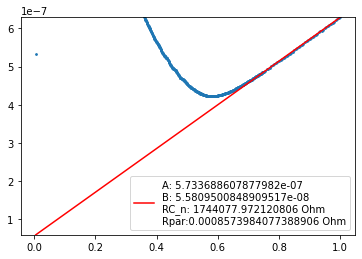

It doesnt like Rpar from list file
Have calculated Rpar  as3.600341149034831e-05 from fit
The stray resistance is 0.0 mohm.


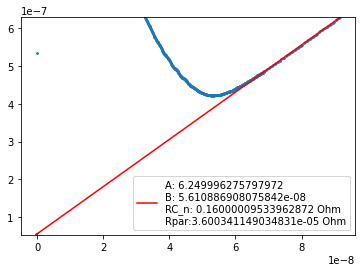

It doesnt like Rpar from list file
Have calculated Rpar  as0.0007731280744987814 from fit
The stray resistance is 0.8 mohm.


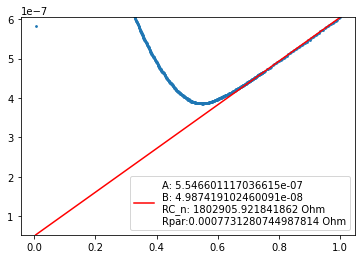

It doesnt like Rpar from list file
Have calculated Rpar  as8.05772500380021e-06 from fit
The stray resistance is 0.0 mohm.


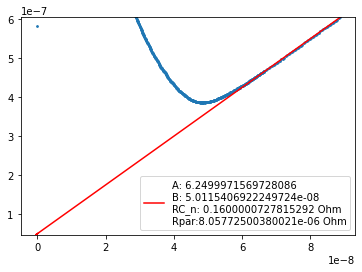

It doesnt like Rpar from list file
Have calculated Rpar  as0.0007448229992317777 from fit
The stray resistance is 0.7 mohm.


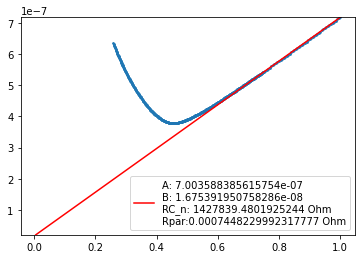

It doesnt like Rpar from list file
Have calculated Rpar  as7.162606598064213e-05 from fit
The stray resistance is 0.1 mohm.


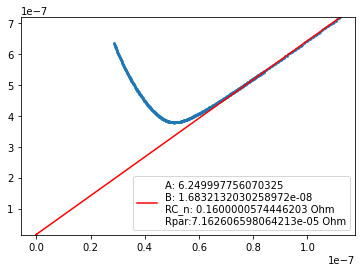

It doesnt like Rpar from list file
Have calculated Rpar  as0.0006199194182648015 from fit
The stray resistance is 0.6 mohm.


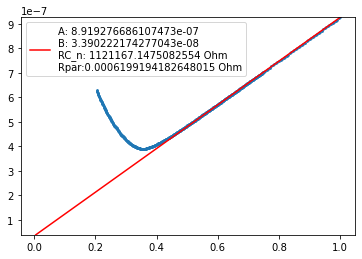

It doesnt like Rpar from list file
Have calculated Rpar  as1.4304482263127056e-05 from fit
The stray resistance is 0.0 mohm.


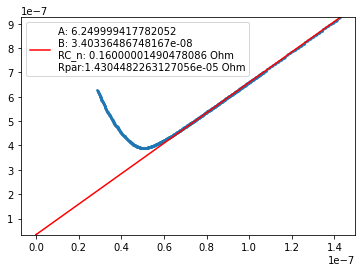

It doesnt like Rpar from list file
Have calculated Rpar  as0.0007853537754017037 from fit
The stray resistance is 0.8 mohm.


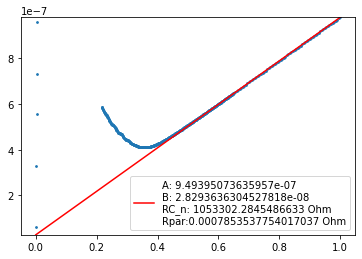

It doesnt like Rpar from list file
Have calculated Rpar  as-2.8266912699964848e-05 from fit
The stray resistance is -0.0 mohm.


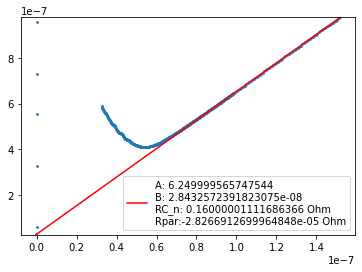

It doesnt like Rpar from list file
Have calculated Rpar  as0.0008182660628463554 from fit
The stray resistance is 0.8 mohm.


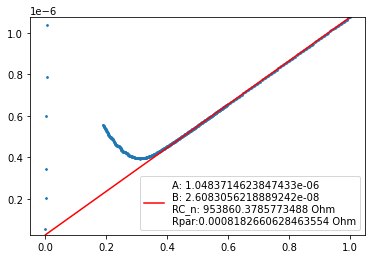

It doesnt like Rpar from list file
Have calculated Rpar  as-3.145778044612923e-07 from fit
The stray resistance is -0.0 mohm.


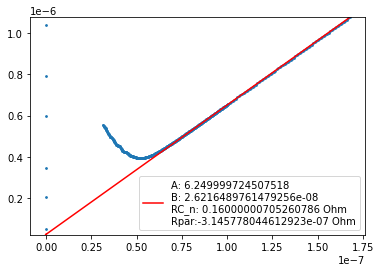

It doesnt like Rpar from list file
Have calculated Rpar  as0.0007561622430069555 from fit
The stray resistance is 0.8 mohm.


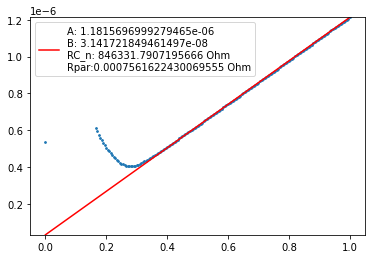

It doesnt like Rpar from list file
Have calculated Rpar  as-0.00019173501503913466 from fit
The stray resistance is -0.2 mohm.


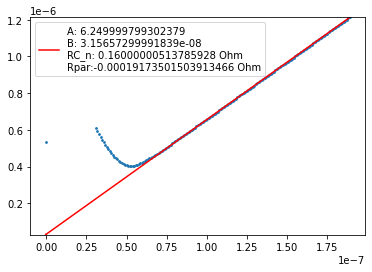

It doesnt like Rpar from list file
Have calculated Rpar  as0.0009053177052783323 from fit
The stray resistance is 0.9 mohm.


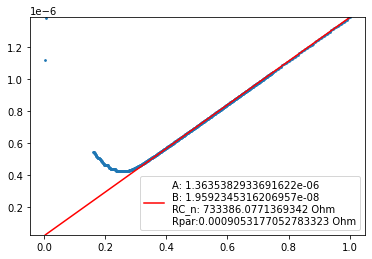

It doesnt like Rpar from list file
Have calculated Rpar  as3.274198272918802e-05 from fit
The stray resistance is 0.0 mohm.


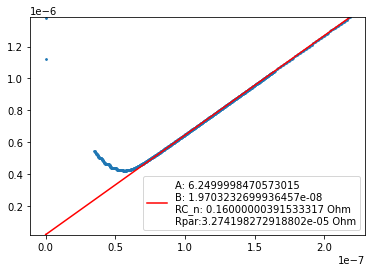

It doesnt like Rpar from list file
Have calculated Rpar  as0.001993252937524772 from fit
The stray resistance is 2.0 mohm.


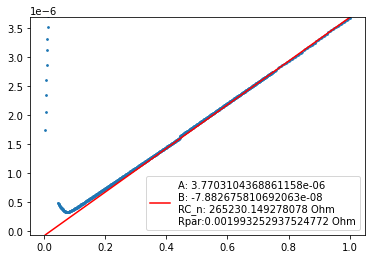

It doesnt like Rpar from list file
Have calculated Rpar  as-0.0008940578435126062 from fit
The stray resistance is -0.9 mohm.


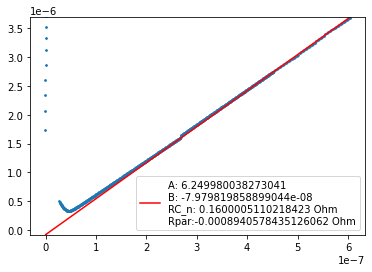

It doesnt like Rpar from list file
Have calculated Rpar  as0.0010137805778620633 from fit
The stray resistance is 1.0 mohm.


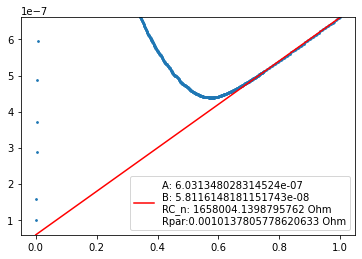

It doesnt like Rpar from list file
Have calculated Rpar  as-8.115074960929943e-05 from fit
The stray resistance is -0.1 mohm.


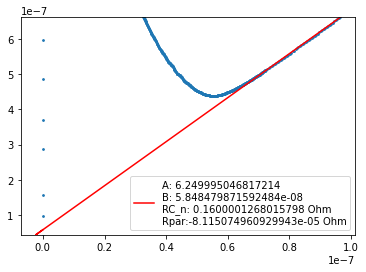

It doesnt like Rpar from list file
Have calculated Rpar  as0.0008295894563816064 from fit
The stray resistance is 0.8 mohm.


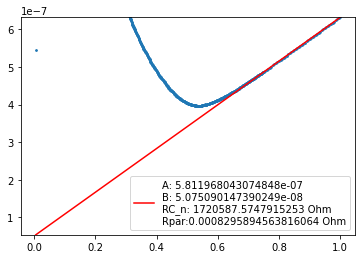

It doesnt like Rpar from list file
Have calculated Rpar  as1.4445351010321007e-05 from fit
The stray resistance is 0.0 mohm.


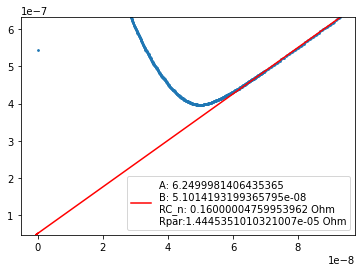

It doesnt like Rpar from list file
Have calculated Rpar  as0.0006111286759520661 from fit
The stray resistance is 0.6 mohm.


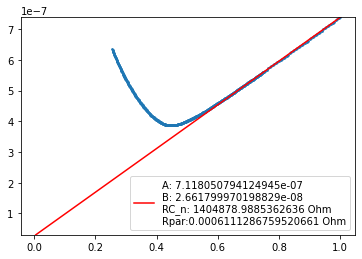

It doesnt like Rpar from list file
Have calculated Rpar  as1.211494418419428e-05 from fit
The stray resistance is 0.0 mohm.


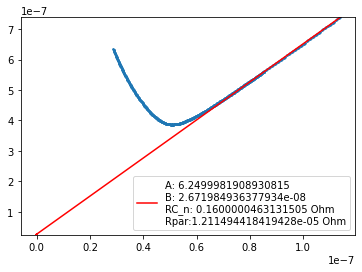

It doesnt like Rpar from list file
Have calculated Rpar  as0.0006407071948703656 from fit
The stray resistance is 0.6 mohm.


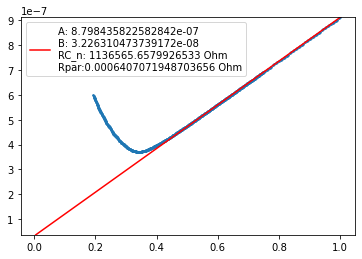

It doesnt like Rpar from list file
Have calculated Rpar  as8.458534131921224e-06 from fit
The stray resistance is 0.0 mohm.


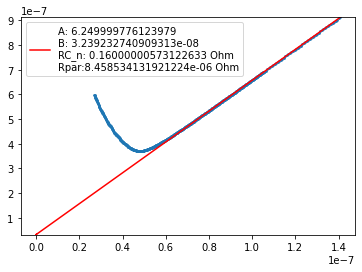

It doesnt like Rpar from list file
Have calculated Rpar  as0.0008324617447929661 from fit
The stray resistance is 0.8 mohm.


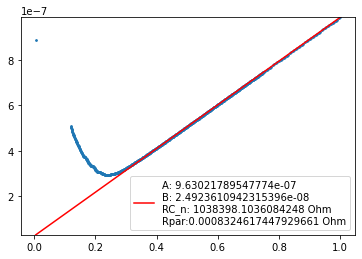

It doesnt like Rpar from list file
Have calculated Rpar  as0.006983584449503402 from fit
The stray resistance is 7.0 mohm.


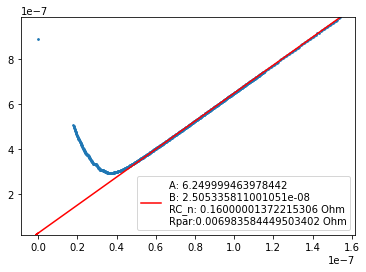

It doesnt like Rpar from list file
Have calculated Rpar  as0.0007431423172316364 from fit
The stray resistance is 0.7 mohm.


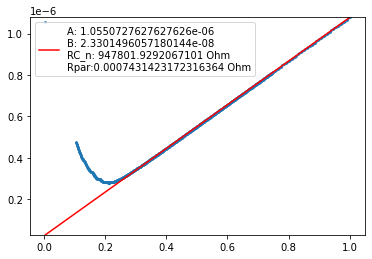

It doesnt like Rpar from list file
Have calculated Rpar  as2.5337144001594308e-05 from fit
The stray resistance is 0.0 mohm.


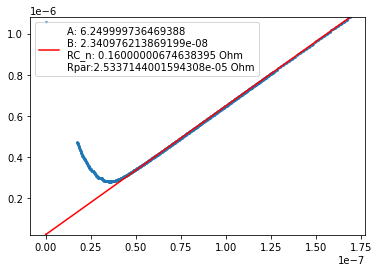

It doesnt like Rpar from list file
Have calculated Rpar  as0.0006470492222110919 from fit
The stray resistance is 0.6 mohm.


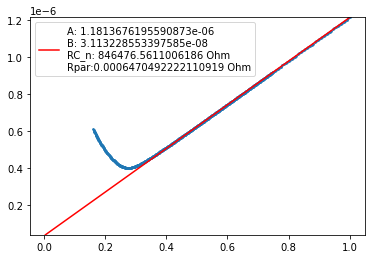

It doesnt like Rpar from list file
Have calculated Rpar  as-8.086246116221126e-06 from fit
The stray resistance is -0.0 mohm.


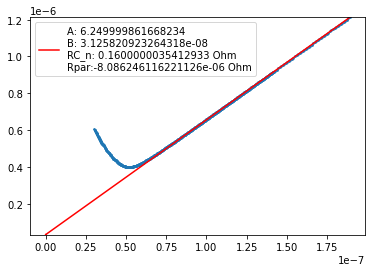

It doesnt like Rpar from list file
Have calculated Rpar  as0.0008961387793827088 from fit
The stray resistance is 0.9 mohm.


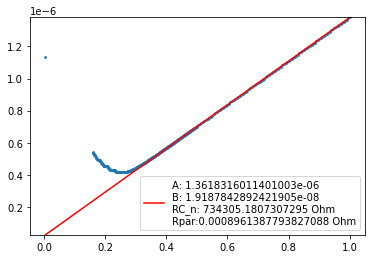

It doesnt like Rpar from list file
Have calculated Rpar  as2.767092055084803e-05 from fit
The stray resistance is 0.0 mohm.


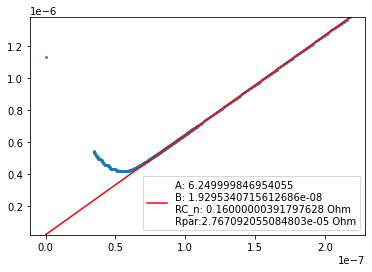

It doesnt like Rpar from list file
Have calculated Rpar  as0.001665801354415755 from fit
The stray resistance is 1.7 mohm.


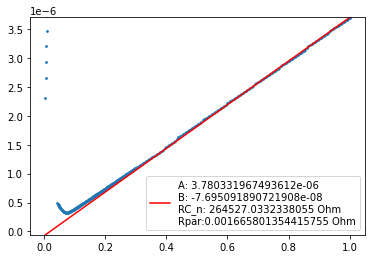

It doesnt like Rpar from list file
Have calculated Rpar  as-0.00012338455887617048 from fit
The stray resistance is -0.1 mohm.


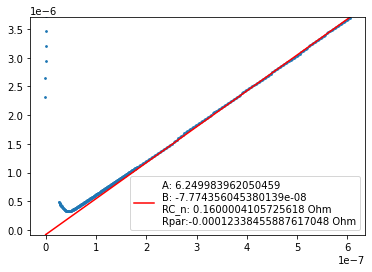

In [127]:
for IVcurve in iv_single.data_single:
    IVcurve.calc_all()

It doesnt like Rpar from list file
Have calculated Rpar  as0.0008573984077388906 from fit
The stray resistance is 0.9 mohm.
RC_n (before): 1744077.972120806
Rpar (before): 0.0008573984077388906


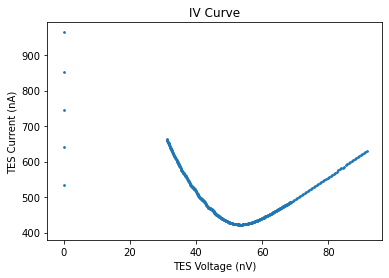

KeyError: 'normal_start'

In [82]:
for IVcurve in iv_single.data_single:
    IVcurve.calc_all()
    print(IVcurve)
    print("RC_n (before):",IVcurve.params['RC_n'])
    print("Rpar (before):", IVcurve.params['Rpar'])
    IVcurve.plot_IV()
    
    for i in range(50):
        IVcurve.fit_loadline_TES(50)
        IVcurve.params['Rpar'] = abs(IVcurve.params['Rpar'])
        IVcurve.calc_values()
    
    IVcurve.plot_IV()
    print("RC_n (after):", IVcurve.params['RC_n'])
    print("Rpar (after):", IVcurve.params['Rpar'])

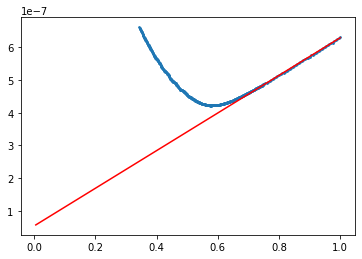

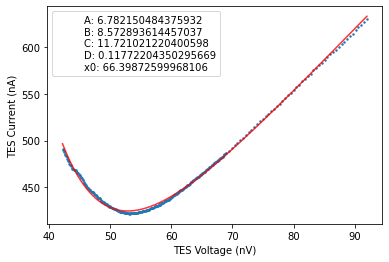

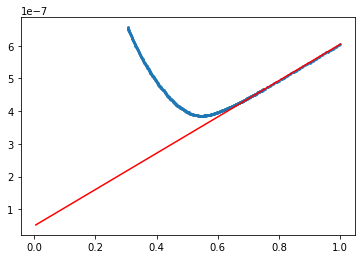

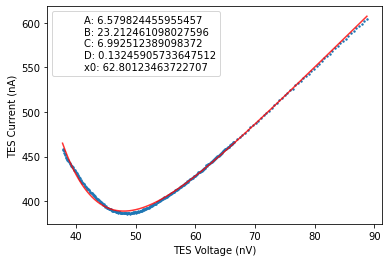

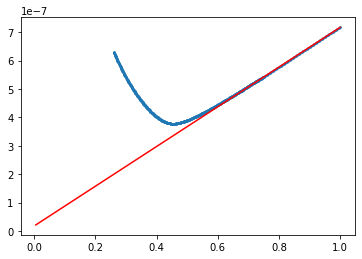

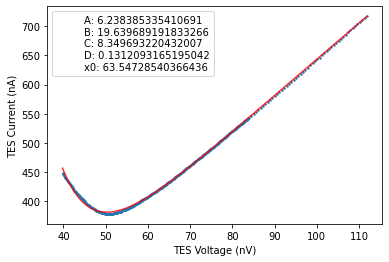

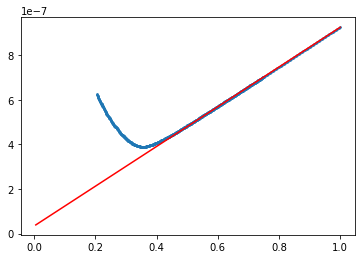

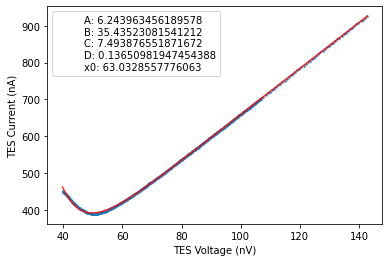

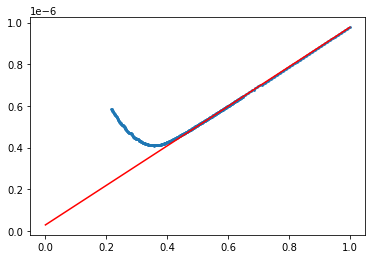

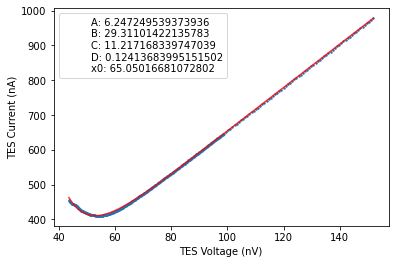

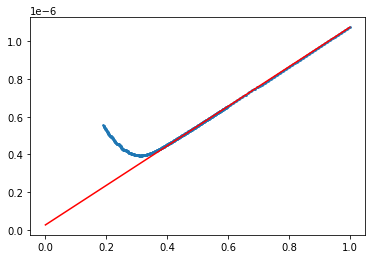

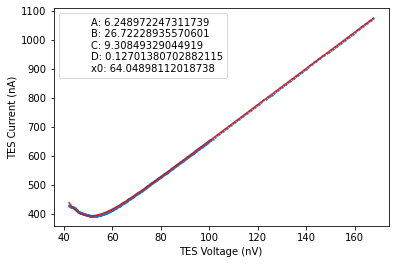

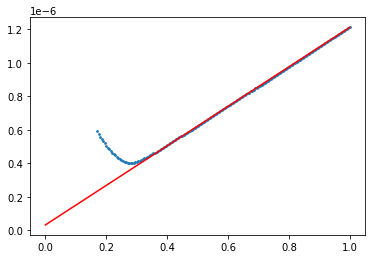

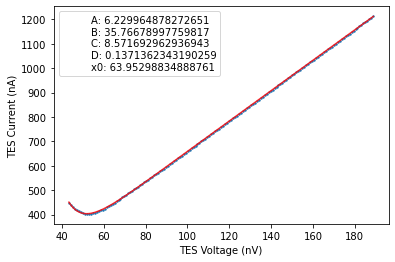

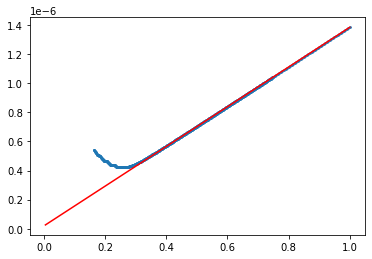

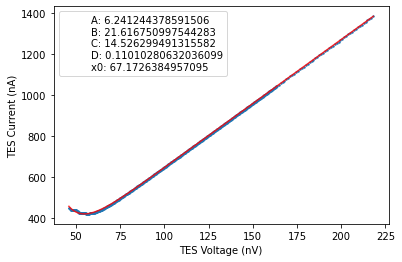

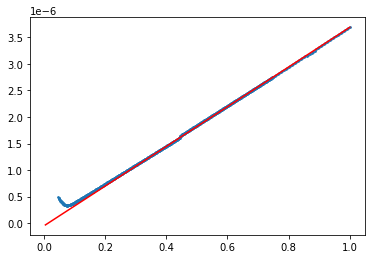

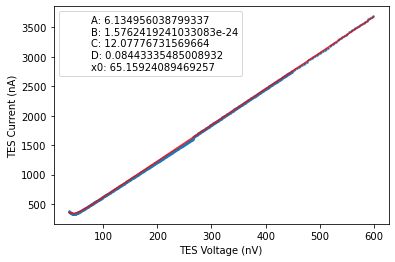

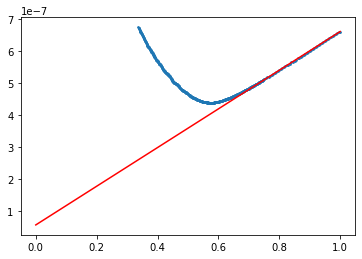

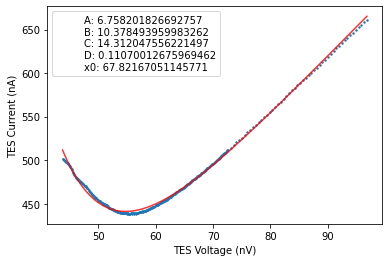

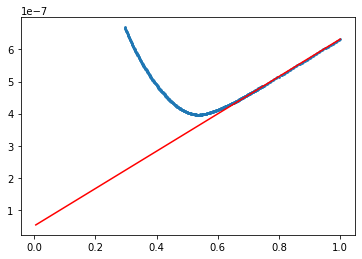

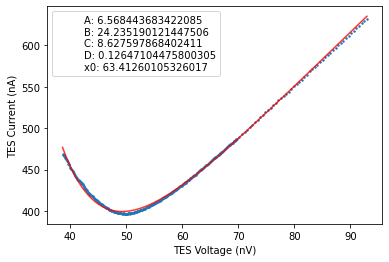

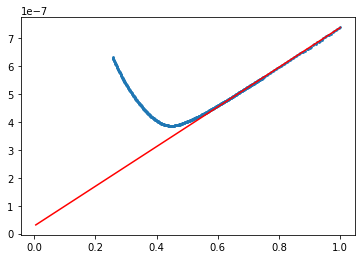

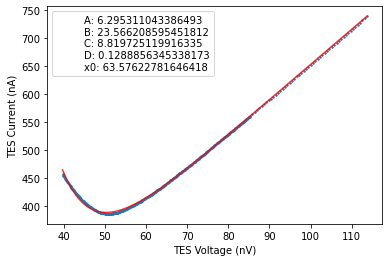

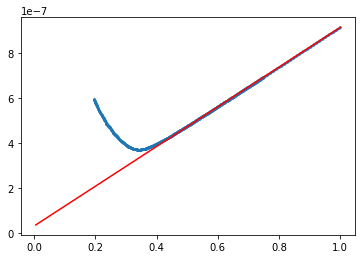

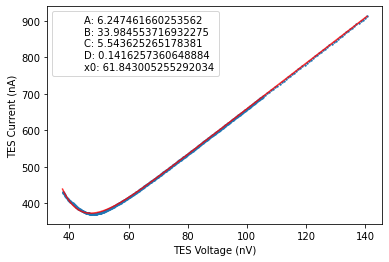

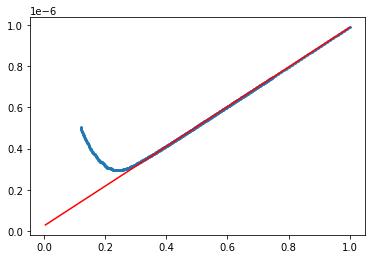

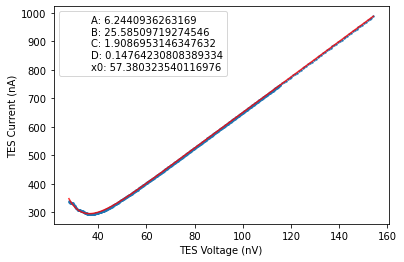

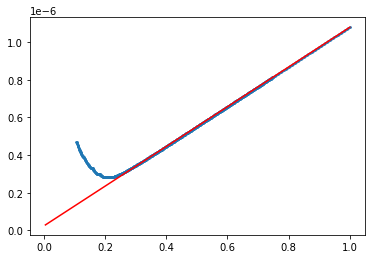

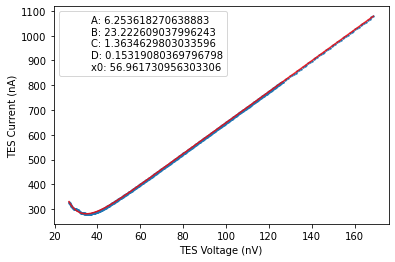

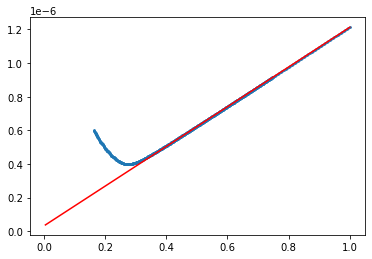

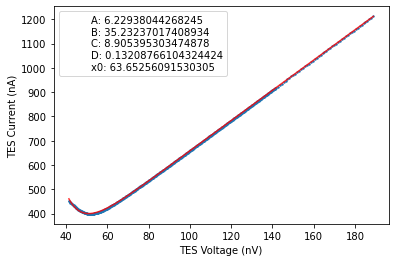

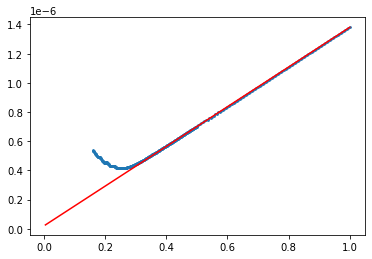

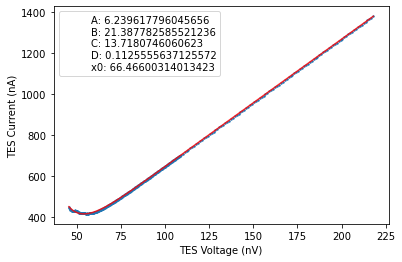

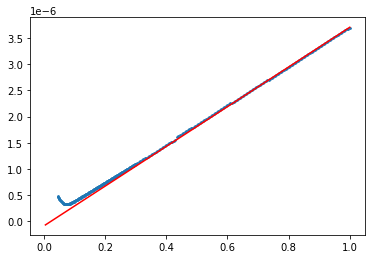

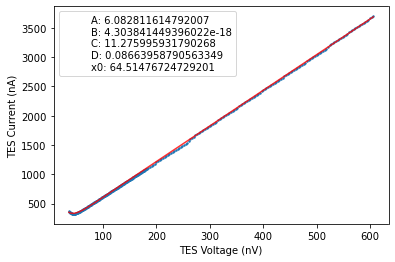

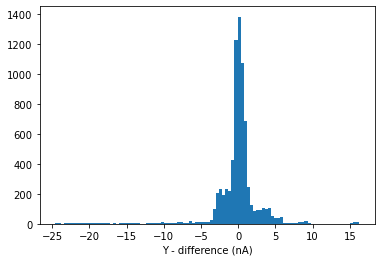

[5.751712320930747e-07, 5.549560423819506e-07, 6.99024651935437e-07, 8.915105234251354e-07, 9.49395073635957e-07, 1.0483409089146782e-06, 1.1804465780193404e-06, 1.3633230011393209e-06, 3.740801828912906e-06, 6.054349668232755e-07, 5.811968043074848e-07, 7.108230230802668e-07, 8.786760051164718e-07, 9.633277056781896e-07, 1.0546769641501863e-06, 1.180457584096091e-06, 1.3619182170138763e-06, 3.7882416315077877e-06]


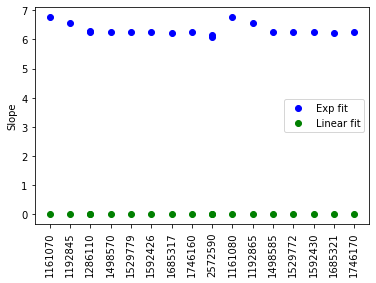

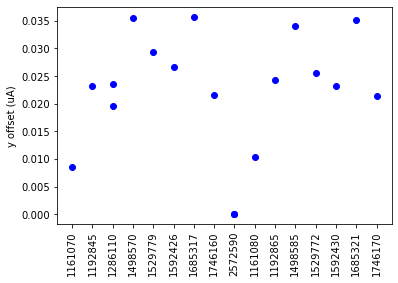

In [10]:
d_list = []
freqs = []
loadlines = []
slopes = []
offsets = []

for IV_curve in iv_single.data_single:
    IV_curve.calc_all()
    V_TES_no_s = IV_curve.V_TES[:IV_curve.jump_index]
    
    # Grab all data from the right of the lowest point of the curve, and half of the points on the left
    # Fit does not work well when using all the data points in the transition region
    nfit1 = int(0.5*len(V_TES_no_s[IV_curve.IV_min:]))
    nfit2 = len(V_TES_no_s[:IV_curve.IV_min])
    nfit = nfit1 + nfit2
    
    x, y = IV_curve.V_bias[:IV_curve.jump_index], IV_curve.I_TES[:IV_curve.jump_index]
    plt.scatter(x, y, s=3)
    plt.plot(IV_curve.V_bias, IV_curve.params['loadline_n'], color='r')
    plt.show()
    
    try:
        popt = IV_curve.fit_exp(nfit, IV_curve.V_TES, IV_curve.I_TES, plot=True)
        new_distances = IV_curve.calc_distance(nfit, popt)
        d_list = d_list + new_distances
        
        freqs.append(IV_curve.params['frequency'])
        slopes.append(popt[0])
        offsets.append(popt[1] / 1000)
        loadlines.append(IV_curve.params['slope_n'])
    except RuntimeError:
        print("Could not fit function")
        
# Filter
cutoff = int(0.05*len(d_list))

plt.hist(d_list[cutoff:-cutoff], bins=100)
plt.xlabel("Y - difference (nA)")
plt.show()

print(loadlines)
plt.scatter(freqs, slopes, color='b', label='Exp fit')
plt.scatter(freqs, loadlines, color='g', label='Linear fit')
plt.xticks(rotation=90)
plt.ylabel("Slope")
plt.legend()
plt.show()

plt.scatter(freqs, offsets, color='b', label='Exp fit')
plt.xticks(rotation=90)
plt.ylabel("y offset (uA)")
plt.show()

Nfit:  100 ###############################################


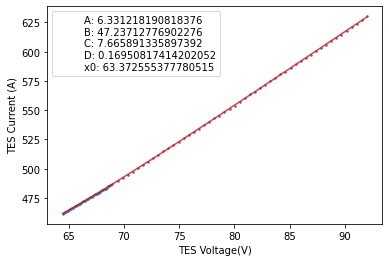

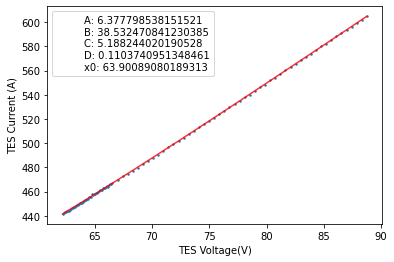

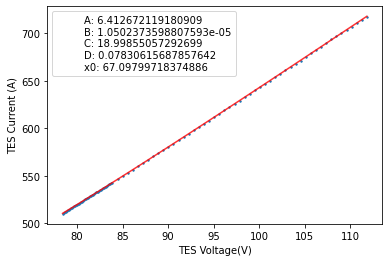

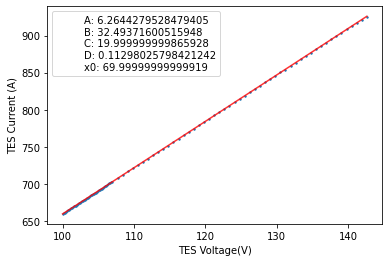

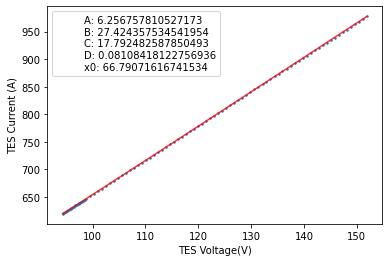

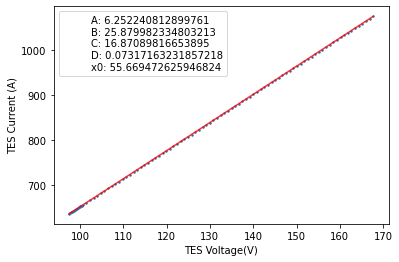

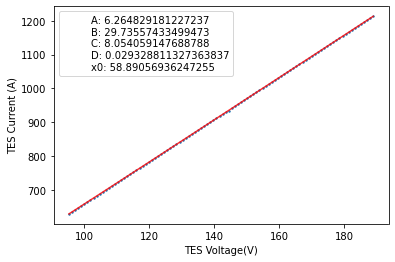

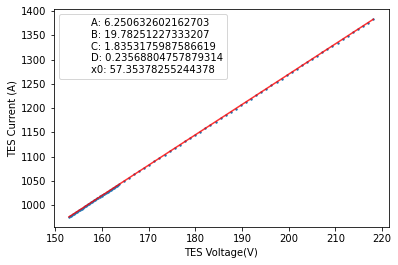

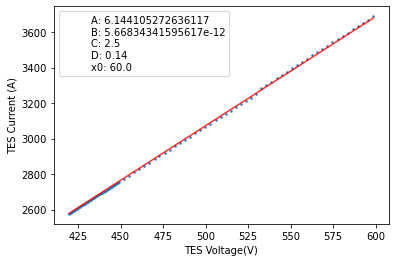

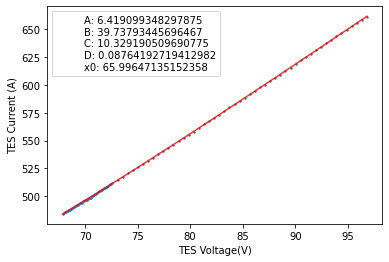

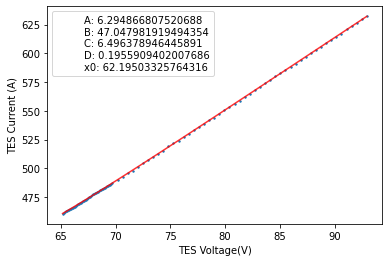

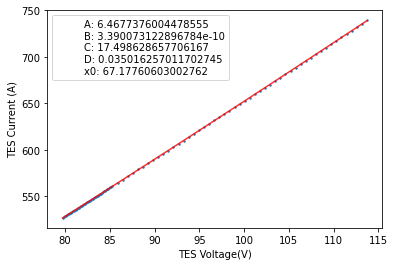

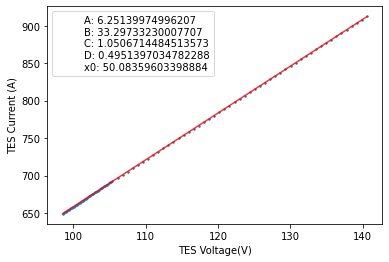

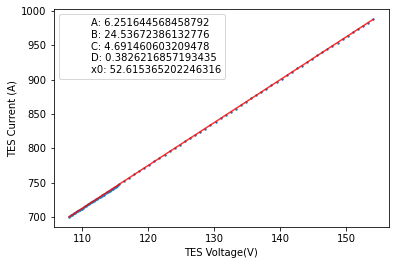

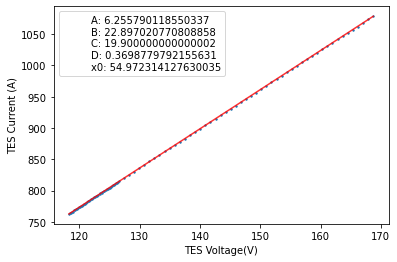

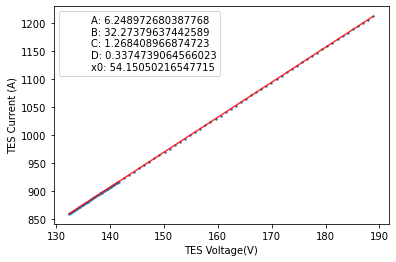

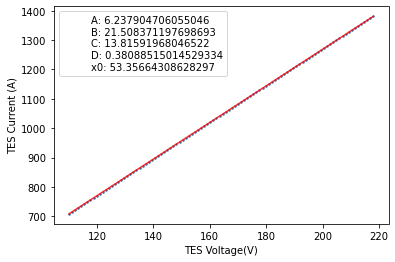

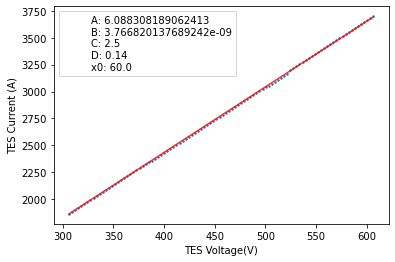

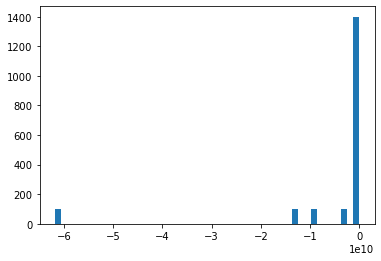

Nfit:  200 ###############################################


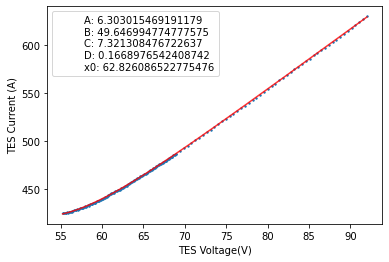

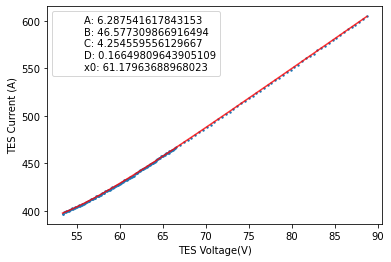

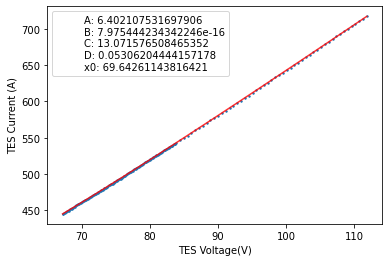

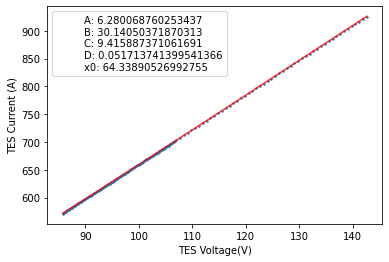

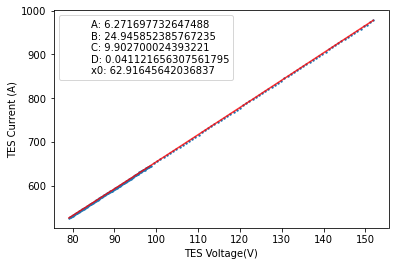

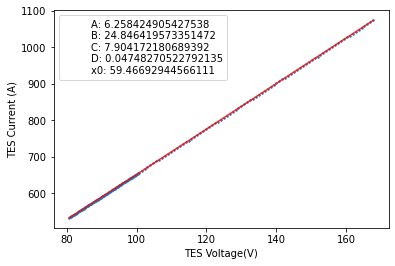

Nfit Limit Reached


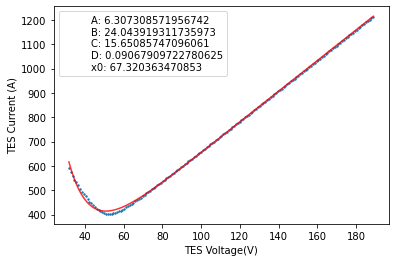

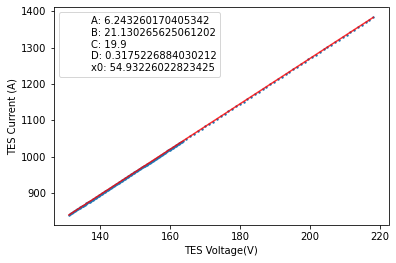

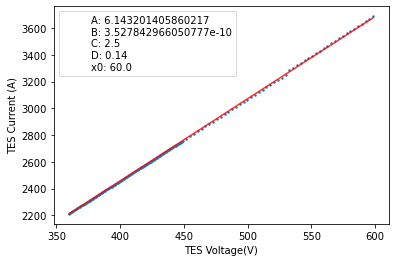

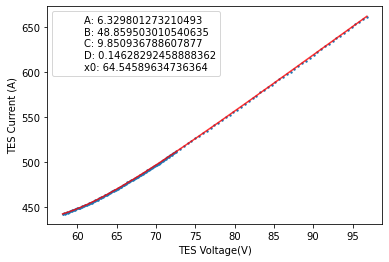

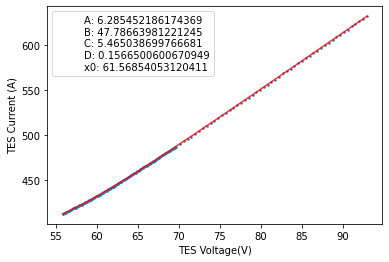

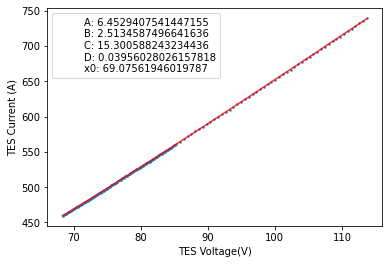

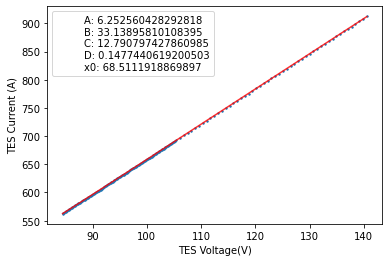

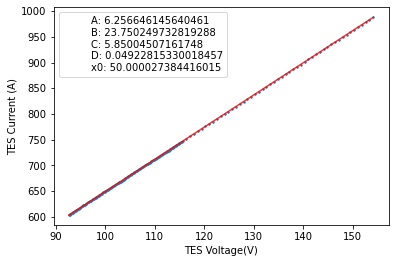

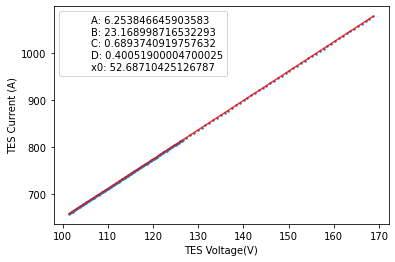

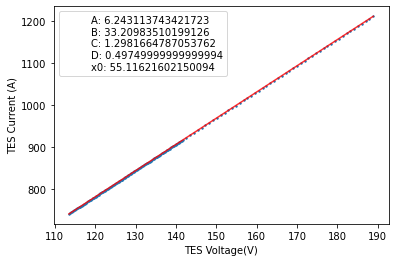

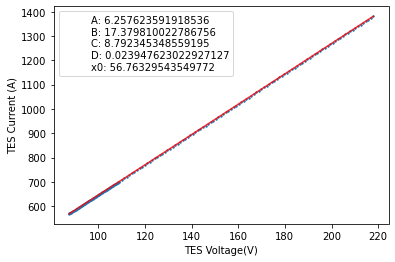

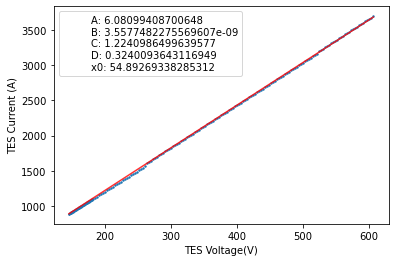

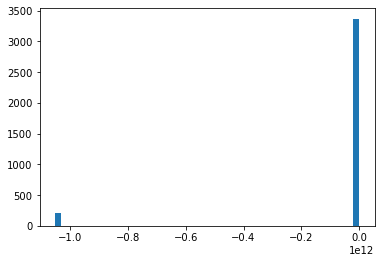

In [127]:
for nfit in range(100, 201, 100):
    print("Nfit: ", nfit, "###############################################")
    d_list = []
    for IV_curve in iv_single.data_single[:]:
        IV_curve.calc_all()
        
        try:
            popt = IV_curve.fit_exp(nfit, IV_curve.V_TES, IV_curve.I_TES, plot=True)
            new_distances = IV_curve.calc_distance(nfit, popt)
            d_list = d_list + new_distances
        except RuntimeError:
            print("Could not fit function")
            
    plt.hist(d_list, bins=50)
    plt.show()

0.16
[-1.81084325 -1.00645291 -0.36162175  1.76755829 11.30191191 10.65445872
  0.58944075  0.5459145   0.75470891]
[1, 2, 5, 11, 12, 13, 14, 16, 24]


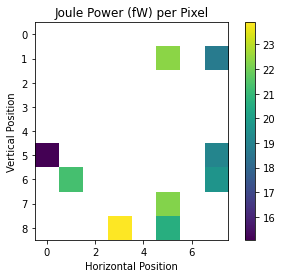

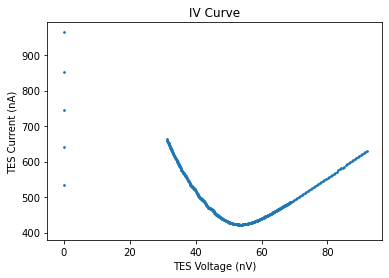

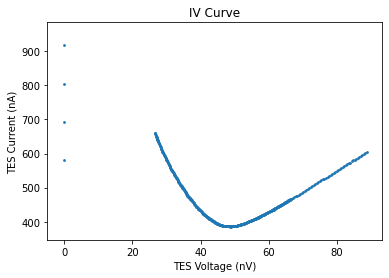

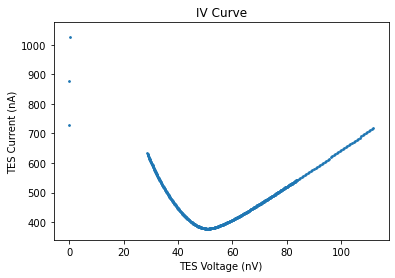

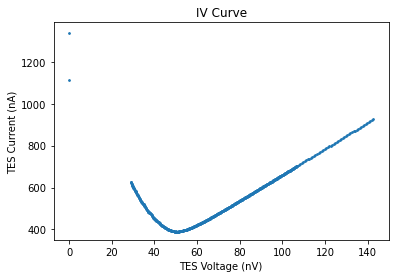

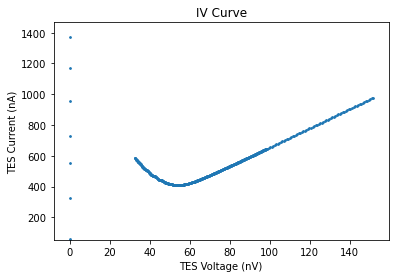

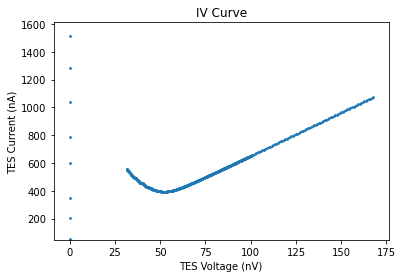

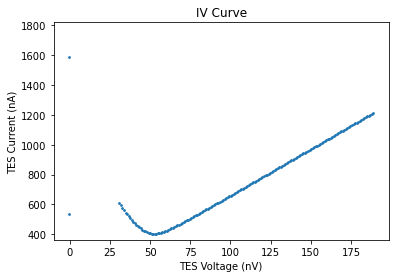

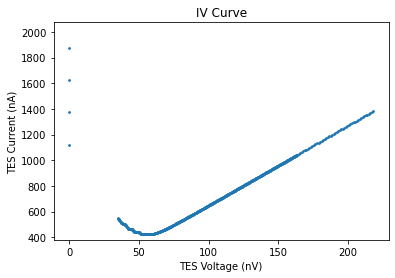

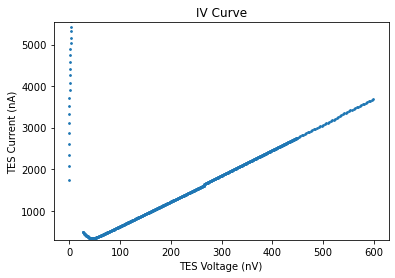

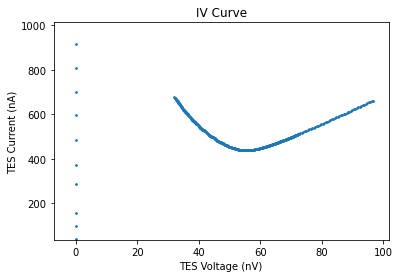

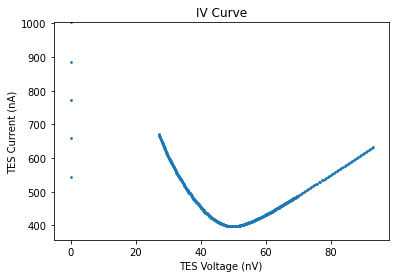

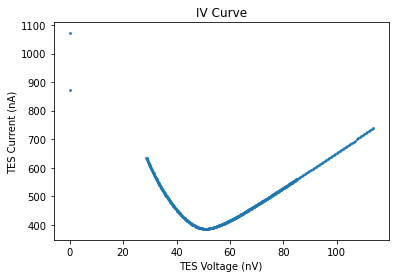

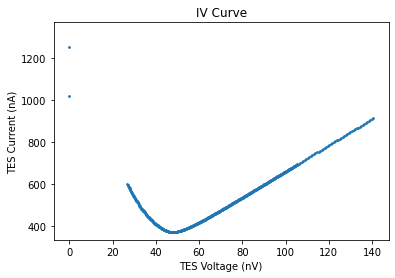

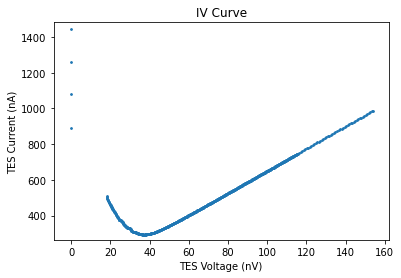

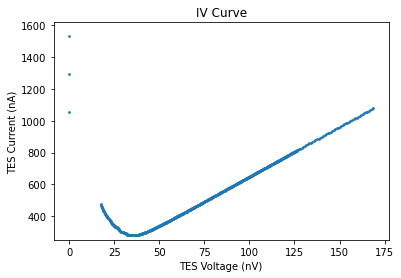

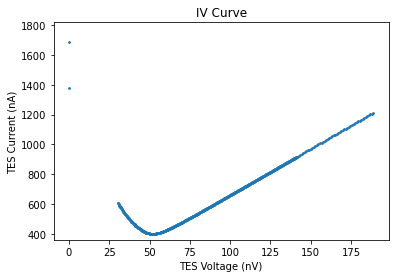

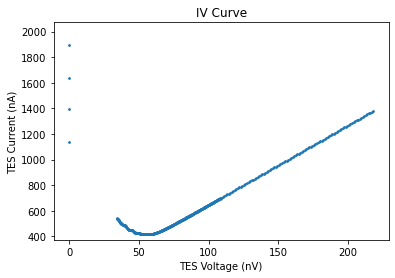

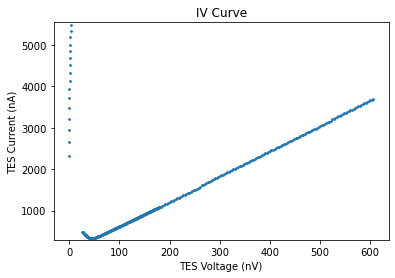

In [65]:
print(iv_single.data_single[0].params['R_N'])

iv_single.create_pixel_dictionary()
iv_single.calc_absorbed_power()
iv_single.plot_array(iv_single.dark_power)

for IV_curve in iv_single.data_single:
    # Calc all values needed for plotting
    IV_curve.calc_all()
    IV_curve.plot_IV()
    

In [61]:
iv_series = IV_series('testing', 'C:/Users/Tom/Desktop/SRON_data_double_selected', [100002.9, 3.18541, 0.004567], double=True)

IVW17C04P03ShClosed_26.91mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_26.95mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.74mA_PBB0pc.qdp
IVW17C04P03ShClosed_29.39mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_34.45mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_37.00mK_BB3.19K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_44.66mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_49.79mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mmGBon_29.38mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mm_27.04mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mm_29.39mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp


C:  4.52583941823502
D:  0.00029783302585655036
C:  4.525839418286868
D:  0.0004716220938710171


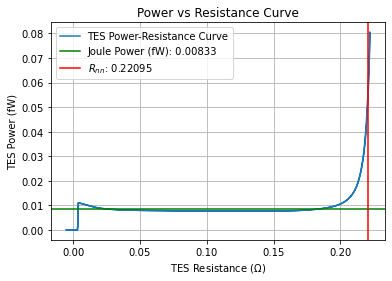

In [62]:
for entry in iv_series.data_double[0:1]:    
    for i in range(1):   # was 10
        entry.R_stray = 1/1000
        entry.calc_all()  
        #entry.plotRaw()
        entry.plotPR()
        

In [65]:
iv_series.analyse_IV(0.0016, 0.001, 1000, debug=True)

AttributeError: 'IV_series' object has no attribute 'data'

<h1> Classifying Datasets </h1>

In [97]:
rootdir = r'C:\Users\Tom\Desktop\SRON_data_double'

classifier = Classifier(rootdir)

1

In [98]:
classifier.create_trainingdata()

15 files loaded
The above 0 file(s) were invalid and skipped,                         please check formats manually. Continuing...


In [99]:
classifier.iandv.head()

,Current 2 (I),V_fb 2 (V),Current 3 (I),V_fb 3 (V),Current 4 (I),V_fb 4 (V),Current 5 (I),V_fb 5 (V),Current 6 (I),V_fb 6 (V),...,Current 12 (I),V_fb 12 (V),Current 13 (I),V_fb 13 (V),Current 14 (I),V_fb 14 (V),Current 15 (I),V_fb 15 (V),Current 16 (I),V_fb 16 (V)
0,29.993226,-0.006142,150.010162,-0.048121,29.993226,-0.005990,29.993226,-0.005960,29.993226,-0.006070,...,29.993226,-0.004442,29.993226,-0.004239,150.010162,-0.368799,29.993226,-0.045017,29.993226,-0.045015
1,-29.993226,0.006802,-150.010162,0.063373,-29.993226,0.006826,-29.993226,0.006734,-29.993226,0.006562,...,-29.993226,0.005222,-29.993226,0.005075,-150.010162,0.388614,-29.993226,0.069588,-29.993226,0.069553
2,28.991023,-0.005899,139.998760,-0.028246,28.991023,-0.005781,28.991023,-0.005725,28.991023,-0.005862,...,28.991023,-0.004334,28.991023,-0.004144,139.998760,-0.336568,28.991023,-0.039507,28.991023,-0.039512
3,-28.991023,0.006135,-139.998760,0.041556,-28.991023,0.006135,-28.991023,0.006061,-28.991023,0.005888,...,-28.991023,0.004676,-28.991023,0.004510,-139.998760,0.357522,-28.991023,0.064217,-28.991023,0.064145
4,28.007041,-0.005334,129.994944,-0.024281,28.007041,-0.005273,28.007041,-0.005219,28.007041,-0.005330,...,28.007041,-0.003890,28.007041,-0.003724,129.994944,-0.304523,28.007041,-0.033997,28.007041,-0.033997


Change the features.xlsf file, such that it has labels. After this we can create the NN and do some testing.
Copy of features: 
nice_plot (Column J)
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1

In [100]:
feature_folder = r'C:\Users\Tom\Desktop\Thesis_Notebook'

classifier.create_NN(feature_folder)
classifier.model

       mean       std  skewness  kurtosis  grad mean  grad std  grad skewness  \
0 -0.594449  1.261572  0.372979  0.352908   0.370235  1.055945      -0.658185   
1  1.213687  1.083901  0.362426  0.524826  -0.220327  0.886656      -0.704397   
2 -0.599016  1.230411  0.346932  0.386493   0.370956  1.187415      -0.694489   
3 -0.601281  1.006747  0.342287  0.447435   0.371584  0.993191      -0.675587   
4 -0.642439  0.822150  0.296690  0.469755   0.371990  0.673974      -0.600769   

   grad kurtosis  Unnamed: 8  nice_plot (Column J)  
0       0.701997         NaN                     0  
1       0.878599         NaN                     1  
2       0.775057         NaN                     0  
3       0.744916         NaN                     0  
4       0.591578         NaN                     0  
Epoch 1/150
2/2 [==============================] - 0s 0s/step - loss: 0.7106 - accuracy: 0.2500
Epoch 2/150
2/2 [==============================] - 0s 558us/step - loss: 0.7017 - accuracy: 0.2500


In [106]:
# Testing on other dataset:
other_rootdir = r'C:\Users\Tom\Desktop\SRON_data_single\2010-12-17'

classifier2 = Classifier(other_rootdir)
classifier2.create_trainingdata()

14 files loaded
The above 0 file(s) were invalid and skipped,                         please check formats manually. Continuing...


In [107]:
# Note that features.xlsf is now overwritten in feature_folder, so it contains no labels. Currently the label header 
# still needs to be added into the new features.xlsf file (name needs to match the one used in training).
# TODO: Simpler way to use the model on a features.xlsf file with only basic information, for easier and faster use. (Store headers in file?)
header_name = 'nice_plot (Column J)'
classifier.model = load_model('model ' + header_name)
classifier.test_NN(feature_folder)

        mean       std  skewness  kurtosis  grad mean  grad std  \
0   0.051454 -0.319331 -0.552823  0.089433  -0.329009 -0.758798   
1   0.127446 -0.346694 -0.412133 -0.116112  -0.168754 -0.885237   
2  -0.042412 -0.249418 -0.380683 -0.285127  -0.505825  0.353046   
3   0.215271 -0.338097 -1.106202  1.400101   0.043670 -0.367507   
4   0.035113 -0.277115 -0.465030 -0.197051  -0.404397  0.032227   
5   0.512288 -0.306538  0.548114 -0.183966   0.665261 -0.179167   
6   0.350445 -0.378299 -0.377715 -0.212634   0.208358 -1.104771   
7   0.790859  0.116682  1.866684 -0.111852   1.779410  1.627250   
8   0.338744 -0.364249 -1.749016  2.896076   0.182780 -0.817236   
9   0.551320 -0.193908  1.479260 -0.328662   1.116459  0.626892   
10  0.441023 -0.348930  1.296979 -0.812364   0.367203 -0.873433   
11 -3.354427  3.446482  0.082922 -0.827922  -2.680789  2.377994   
12  0.158019 -0.163259  0.041737 -0.887267   0.137305 -0.025111   
13 -0.175141 -0.277327 -0.272095 -0.422652  -0.411674 -0.00614

IndexError: index 9 is out of bounds for axis 0 with size 8

In [95]:
filelist_dir = r'C:\Users\Tom\Desktop\SRON_data_single\FDM\analysis\conductance\darkandoptical.lis'
iv_single = IV_series('hoi', filelist_dir, [], double=False)

In [151]:
#print(iv_single.data_single[0].params['Vbias_max'])
V_bias_max = 50_000
iv_single.data_single[0].fit_loadline(V_bias_max)

0      6.269949e-07
1      6.241095e-07
2      6.212242e-07
3      6.183388e-07
4      6.155409e-07
           ...     
791    5.910144e-08
792    5.848939e-08
793    5.796478e-08
794    5.735273e-08
795    5.682812e-08
Name: V_bias, Length: 796, dtype: float64


NameError: name 'DebugMode' is not defined

In [23]:
#iv_series.data_double[0].df